In [1]:
%load_ext autoreload
%autoreload 2
%autosave 10

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

import matplotlib.pyplot as plt
from plotutils import plot_images_as_grid

from imageprosessing import hist_match_images, enhance_motion_contrast, normalize_data
from sharedvariables import get_video_sessions
from video_session import VideoSession
from imageprosessing import SessionPreprocessor
from patchextraction import SessionPatchExtractor
from patchextraction import SessionPatchExtractor as PE
from cnnlearning import CNN

from learningutils import ImageDataset
from classificationutils import create_probability_map
from plotutils import *
from cnnlearning import TrainingTracker, train
import os
import collections
import pathlib

import scipy
import skimage
from skimage.morphology import binary_dilation as bd

import numpy as np
import torch
import cv2
import copy

from tqdm.contrib import tzip

from patchextraction import extract_patches
from patchextraction import SessionPatchExtractor as PE
from imageprosessing import ImageRegistrator
from collections import OrderedDict

report_images_folder = os.path.join(
    '..', '..', 'thesis-report', 'images', 'mc2-npp32-tp1-ps31-mt0-pr-false-uv-true-17'
)
pathlib.Path(report_images_folder).mkdir(exist_ok=True, parents=False)

# change this
classifier_params = collections.OrderedDict(        
    patch_size=31,
    mixed_channels=True,
    drop_confocal=True,

    n_negatives_per_positive=32,
    negative_extraction_mode=SessionPatchExtractor.CIRCLE,                             
    use_vessel_mask=True
)

# load the correct models
results = TrainingTracker.from_file('tmp-res/mc2-npp32-tp1-ps31-mt0-pr-false-uv-true-17/results.pkl')

## ## ## ## ##
balanced_accuracy = results.recorded_models['best_valid_balanced_accuracy']['valid_classification_results'].balanced_accuracy
print('Model balanced acuracy', balanced_accuracy)

video_sessions = get_video_sessions(marked=True, registered=False, validation=True)
print('loaded Video sessions:', len(video_sessions))
[vs.basename for vs in video_sessions]

Autosaving every 10 seconds
Model balanced acuracy 0.8374299133082639
loaded Video sessions: 2


['Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped',
 'Subject51_Session402_OD_(0,-1)_1.04x1.04_3416_OA790nm1_extract_reg_cropped']

# Performance on training data

Loaded .\data\registered-videos\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped_vessel_mask.png
Loaded .\data\registered-videos\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA850nm_dewarped1_extract_reg_cropped_vessel_mask.png
Loaded .\data\registered-videos\Subject25_Session298_OD_(-2,0)_1.03x1_1642_Confocal_dewarped1_extract_reg_cropped_vessel_mask.png
Loaded .\data\registered-videos\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped_vessel_mask.png
Loaded .\data\registered-videos\Subject3_Session217_OS_(2,0)_1x1_988_OA850nm_dewarped1_extract_reg_cropped_vessel_mask.png
Loaded .\data\registered-videos\Subject3_Session217_OS_(2,0)_1x1_988_Confocal_dewarped1_extract_reg_cropped_vessel_mask.png
Loaded .\data\registered-videos\Subject47_Session375_OD_(0,-1)_1.04x1.04_3056_OA790nm1_extract_reg_cropped_vessel_mask.png
Loaded .\data\registered-videos\Subject47_Session375_OD_(0,-1)_1.04x1.04_3056_OA850nm1_extract_reg_cropped_vessel_mask.

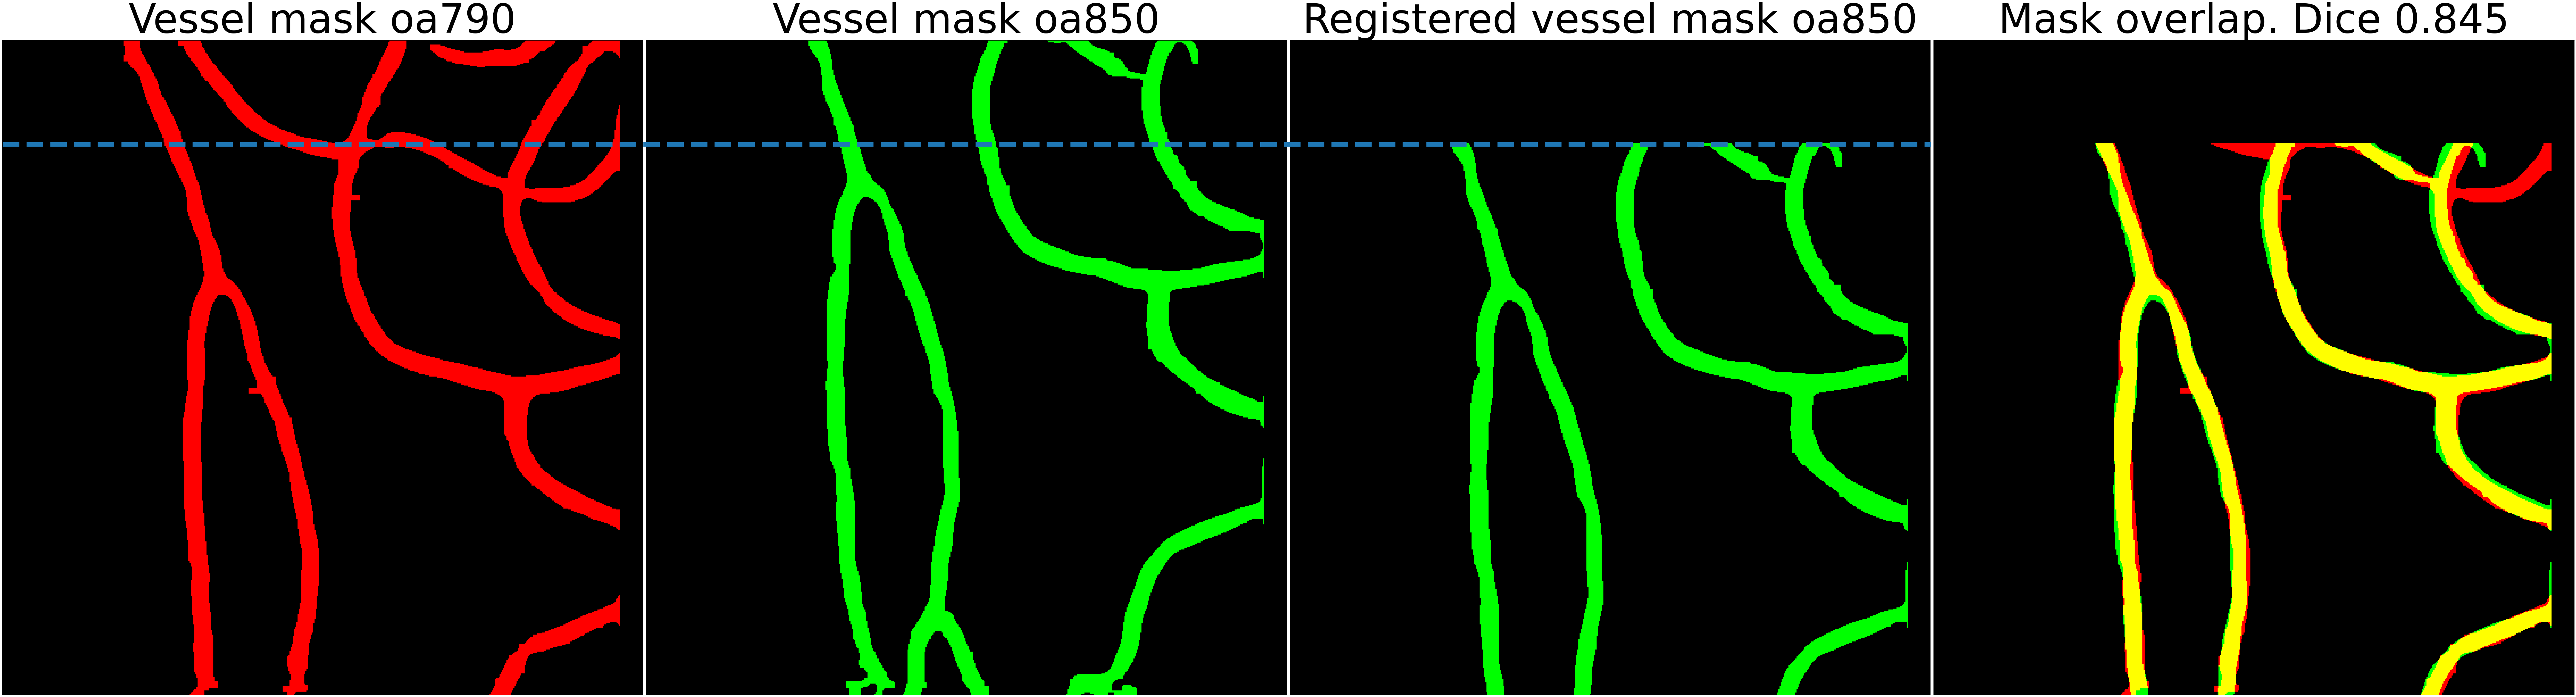

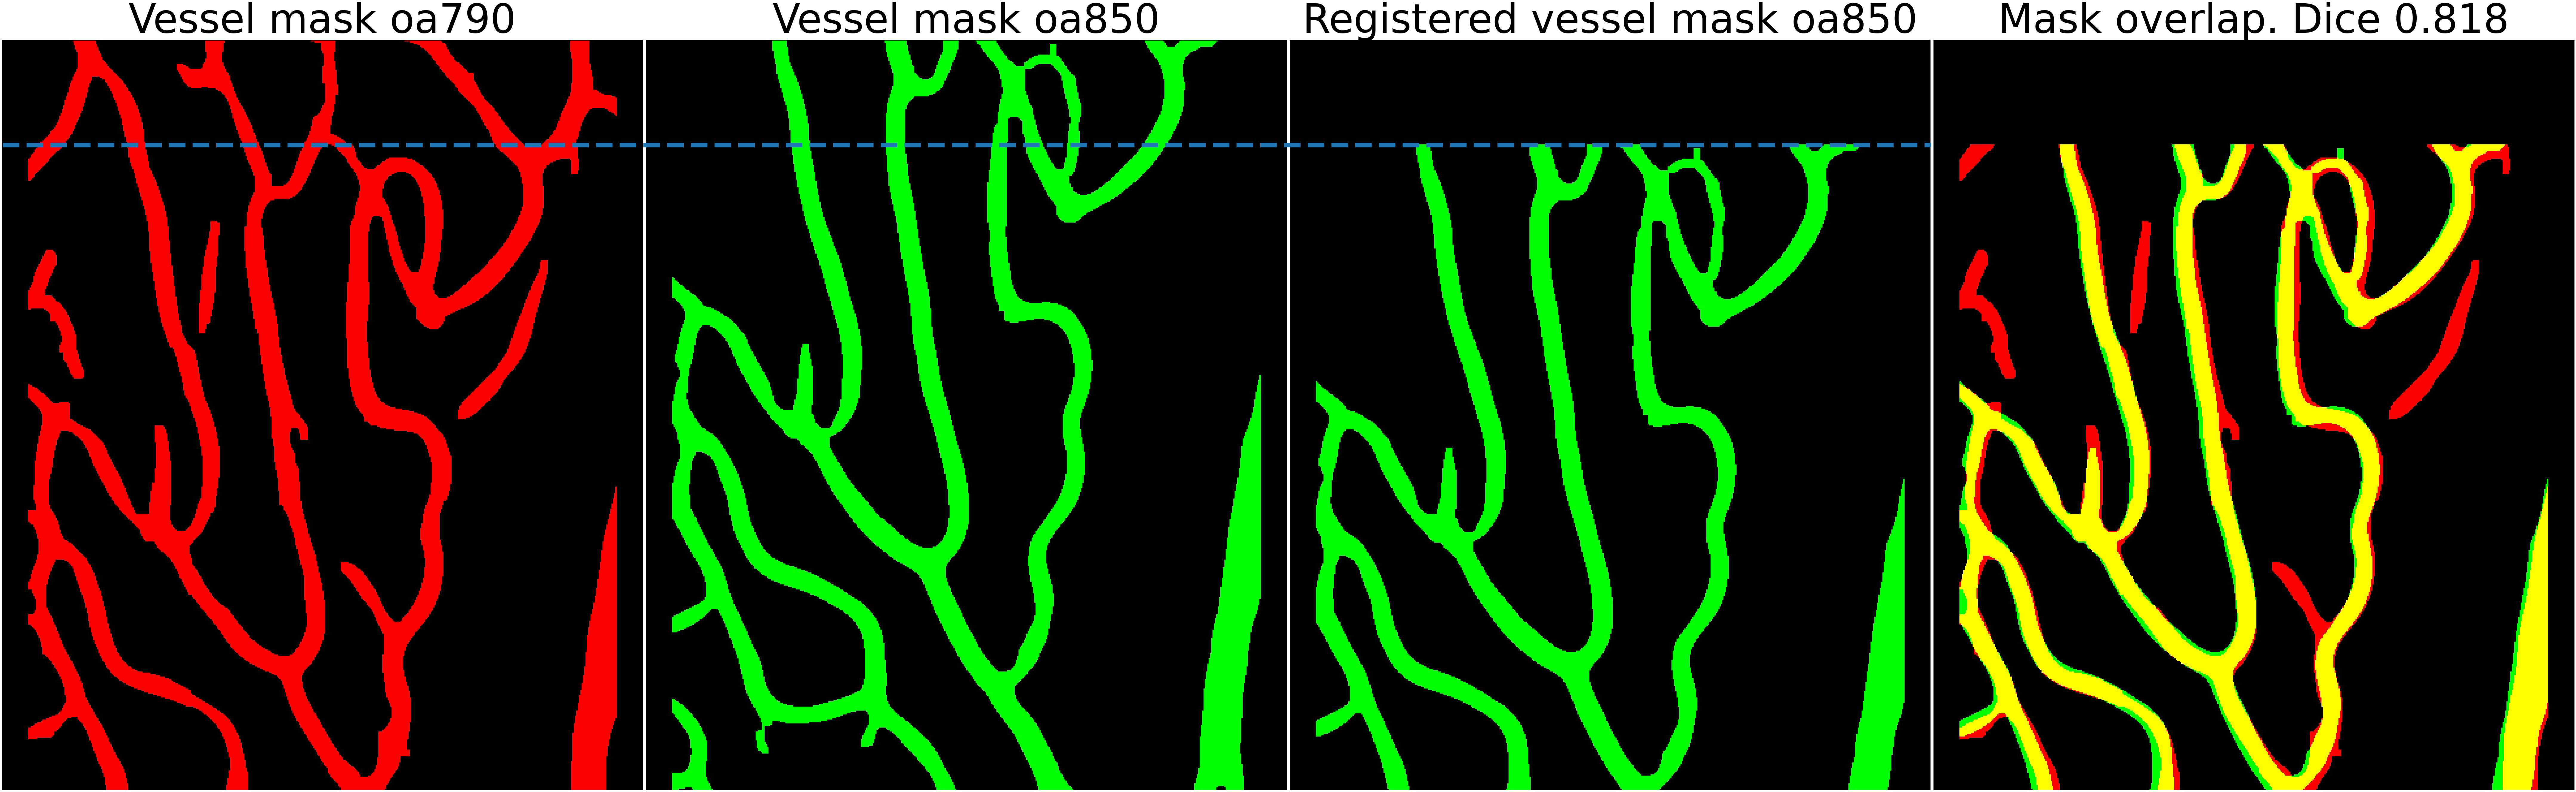

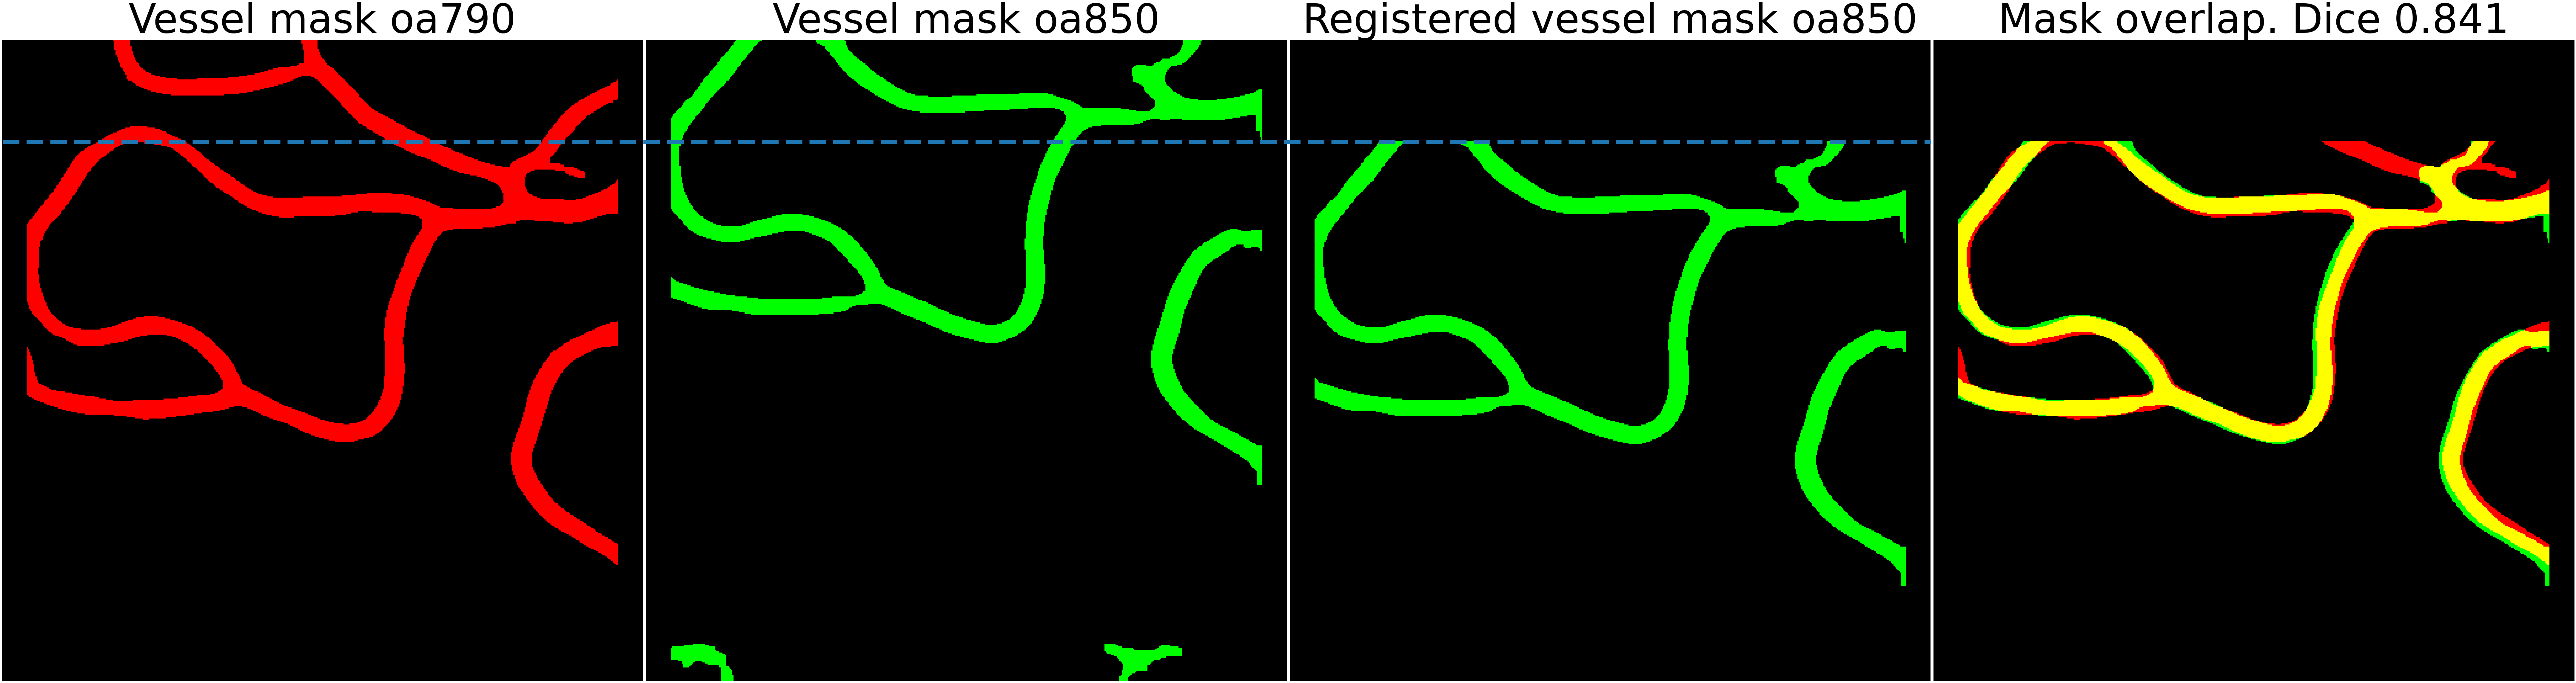

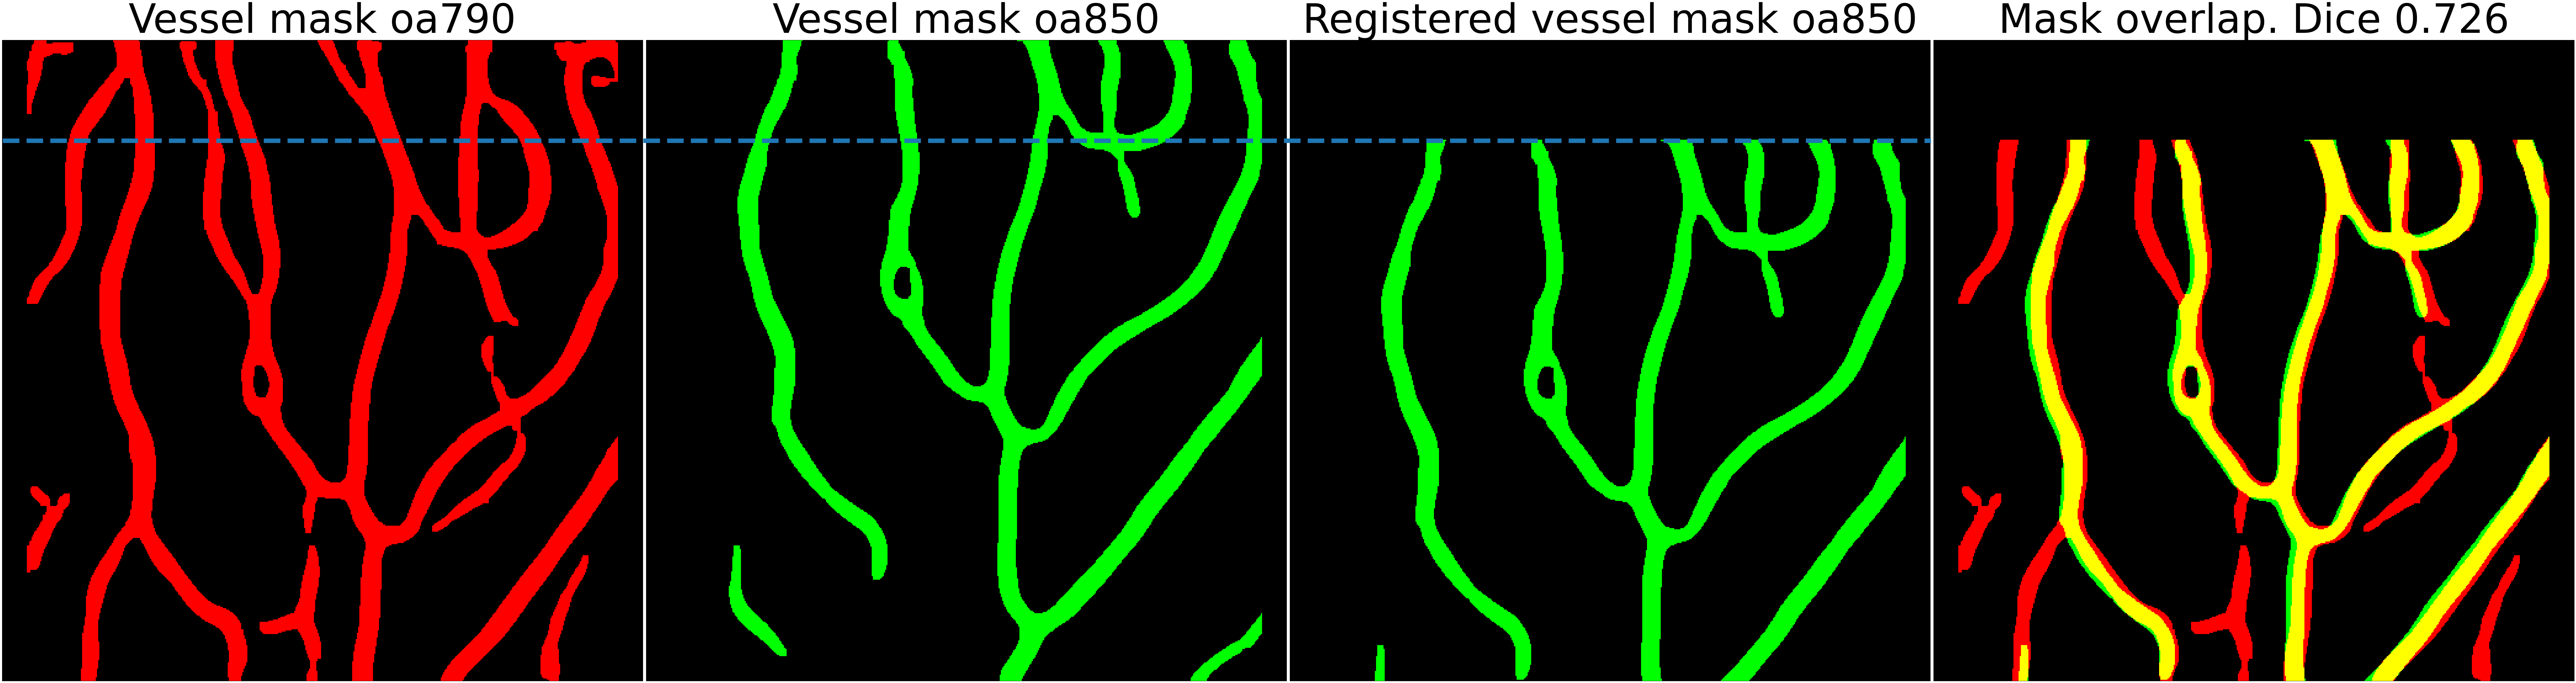

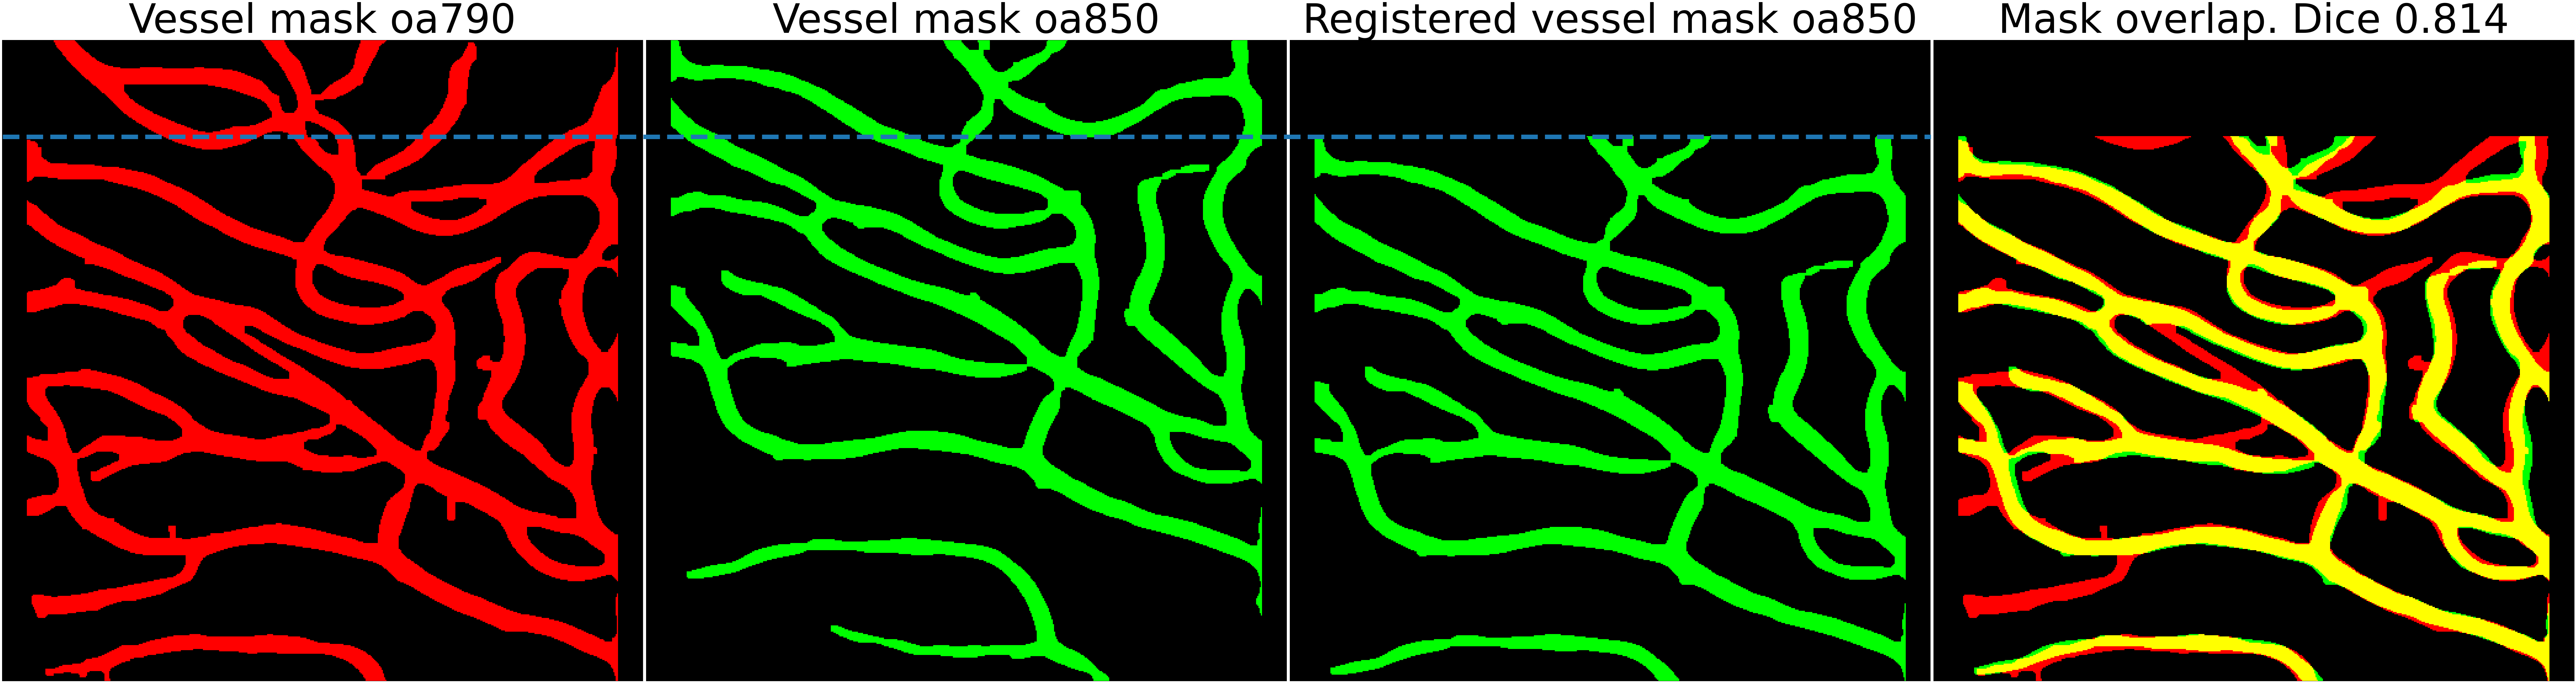

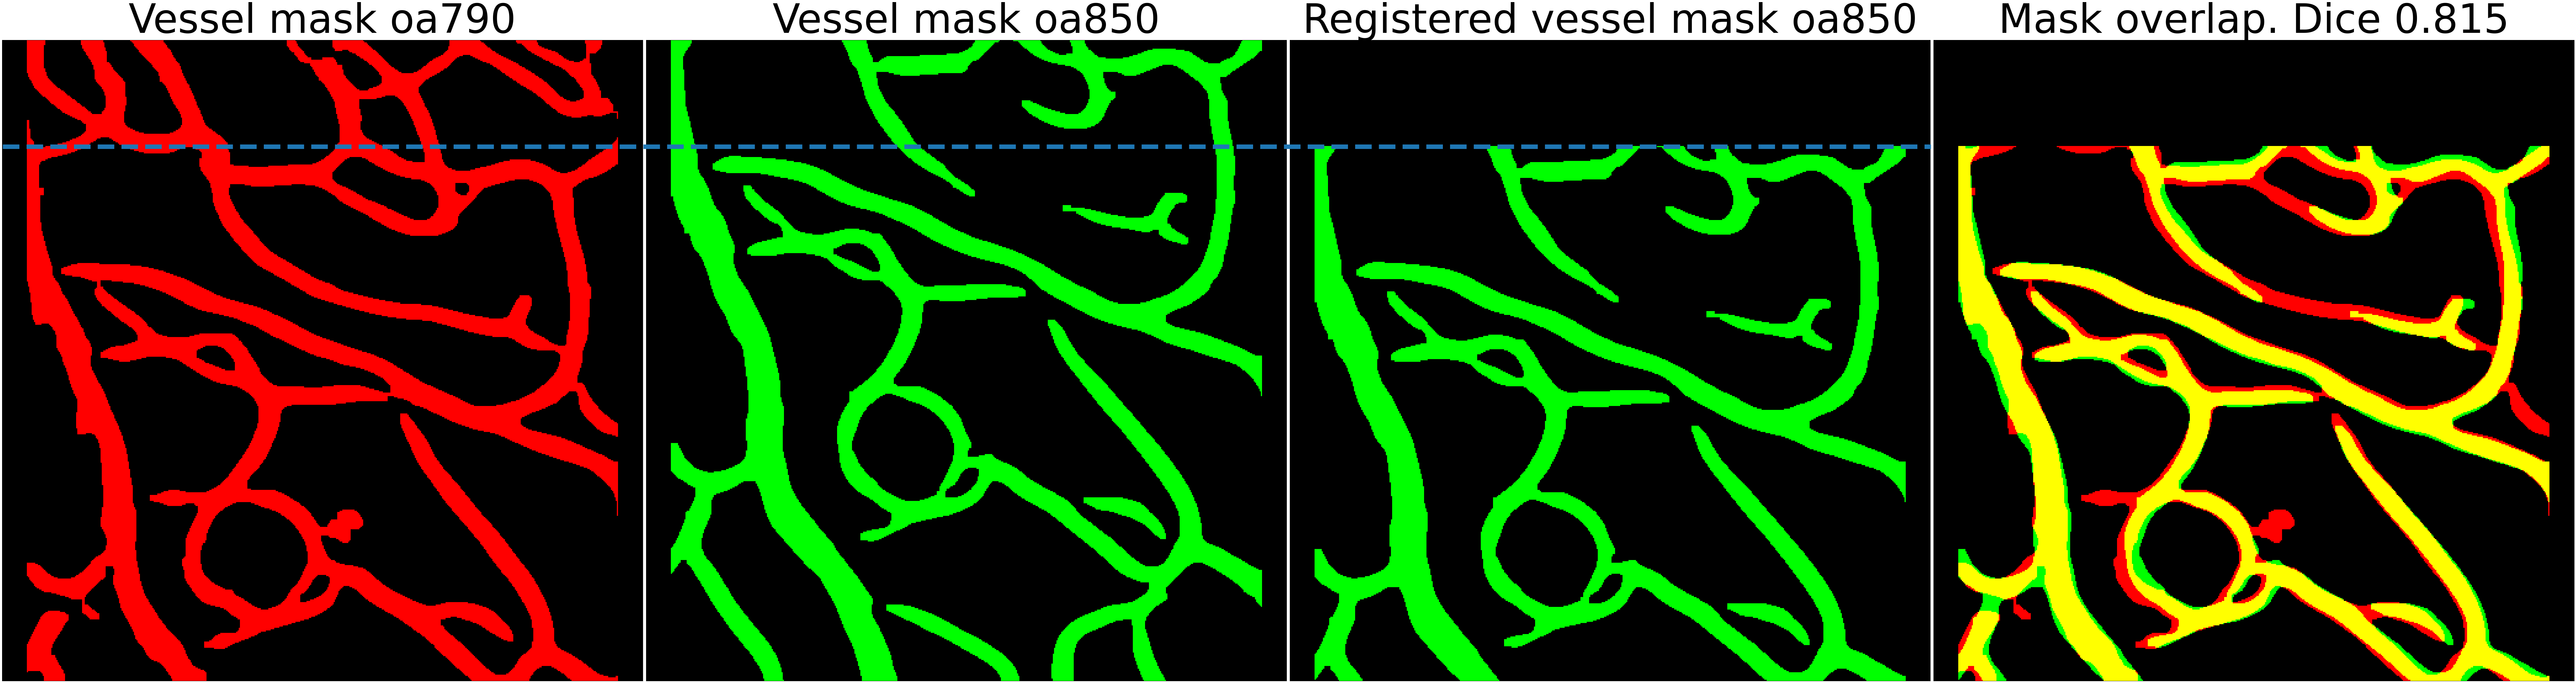

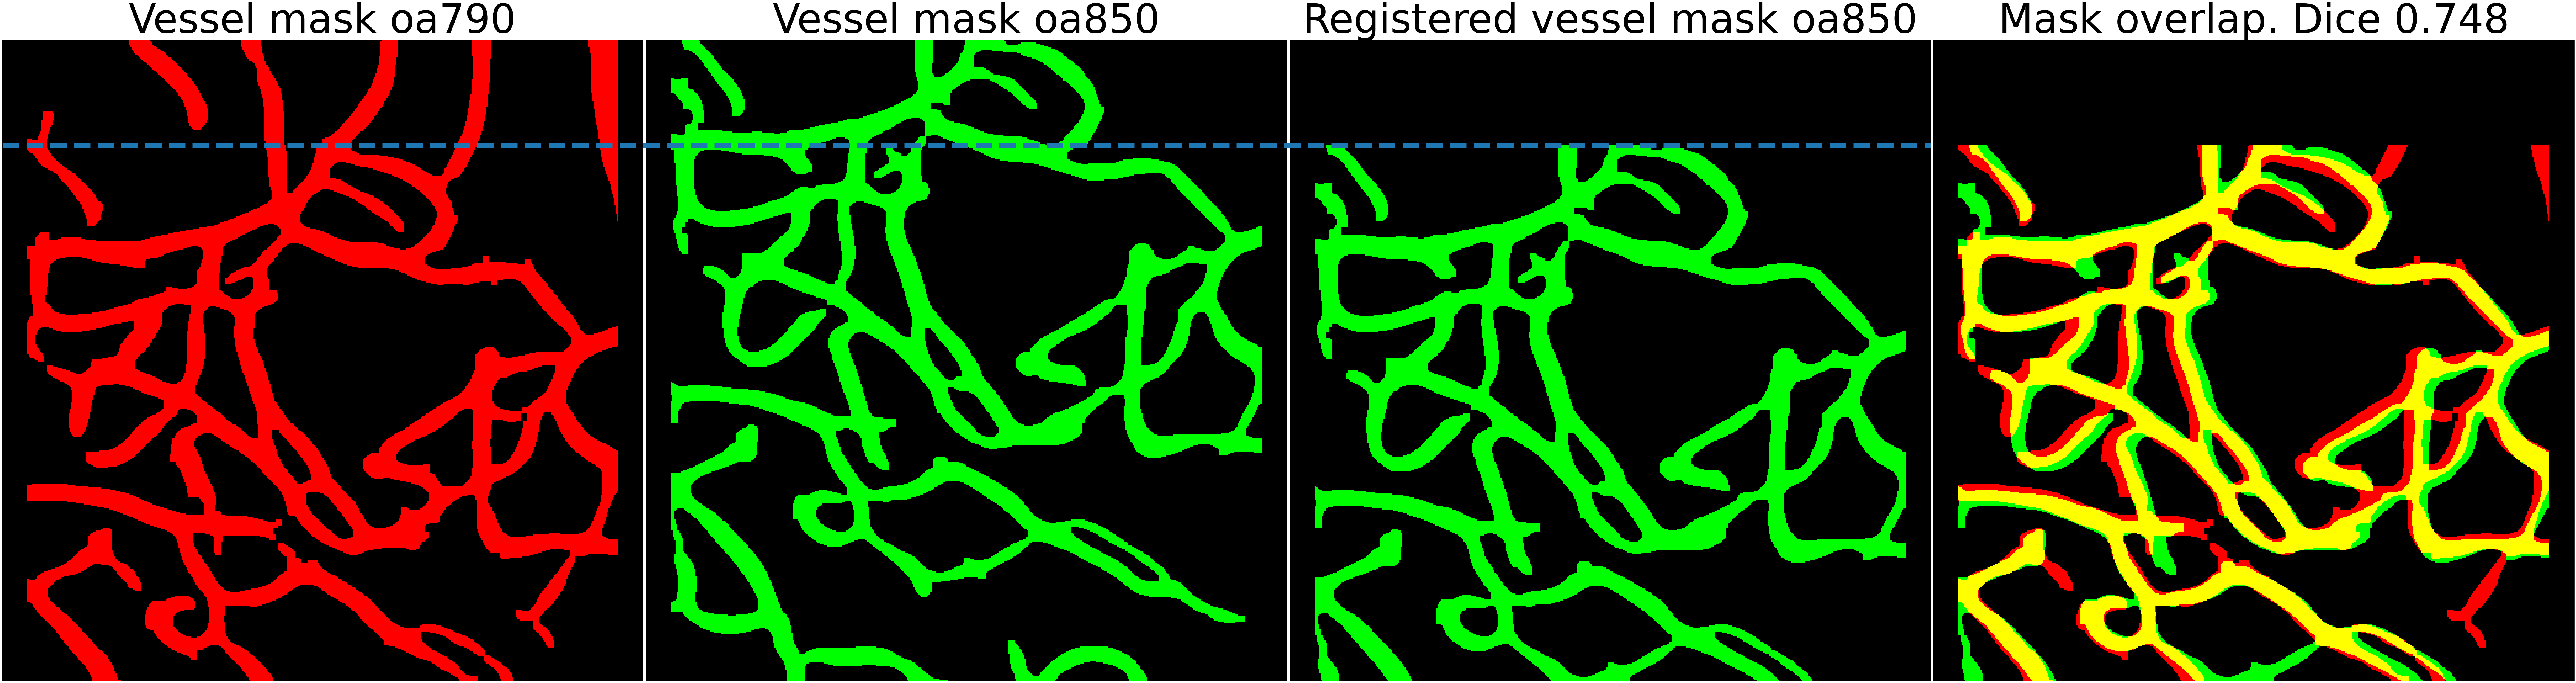

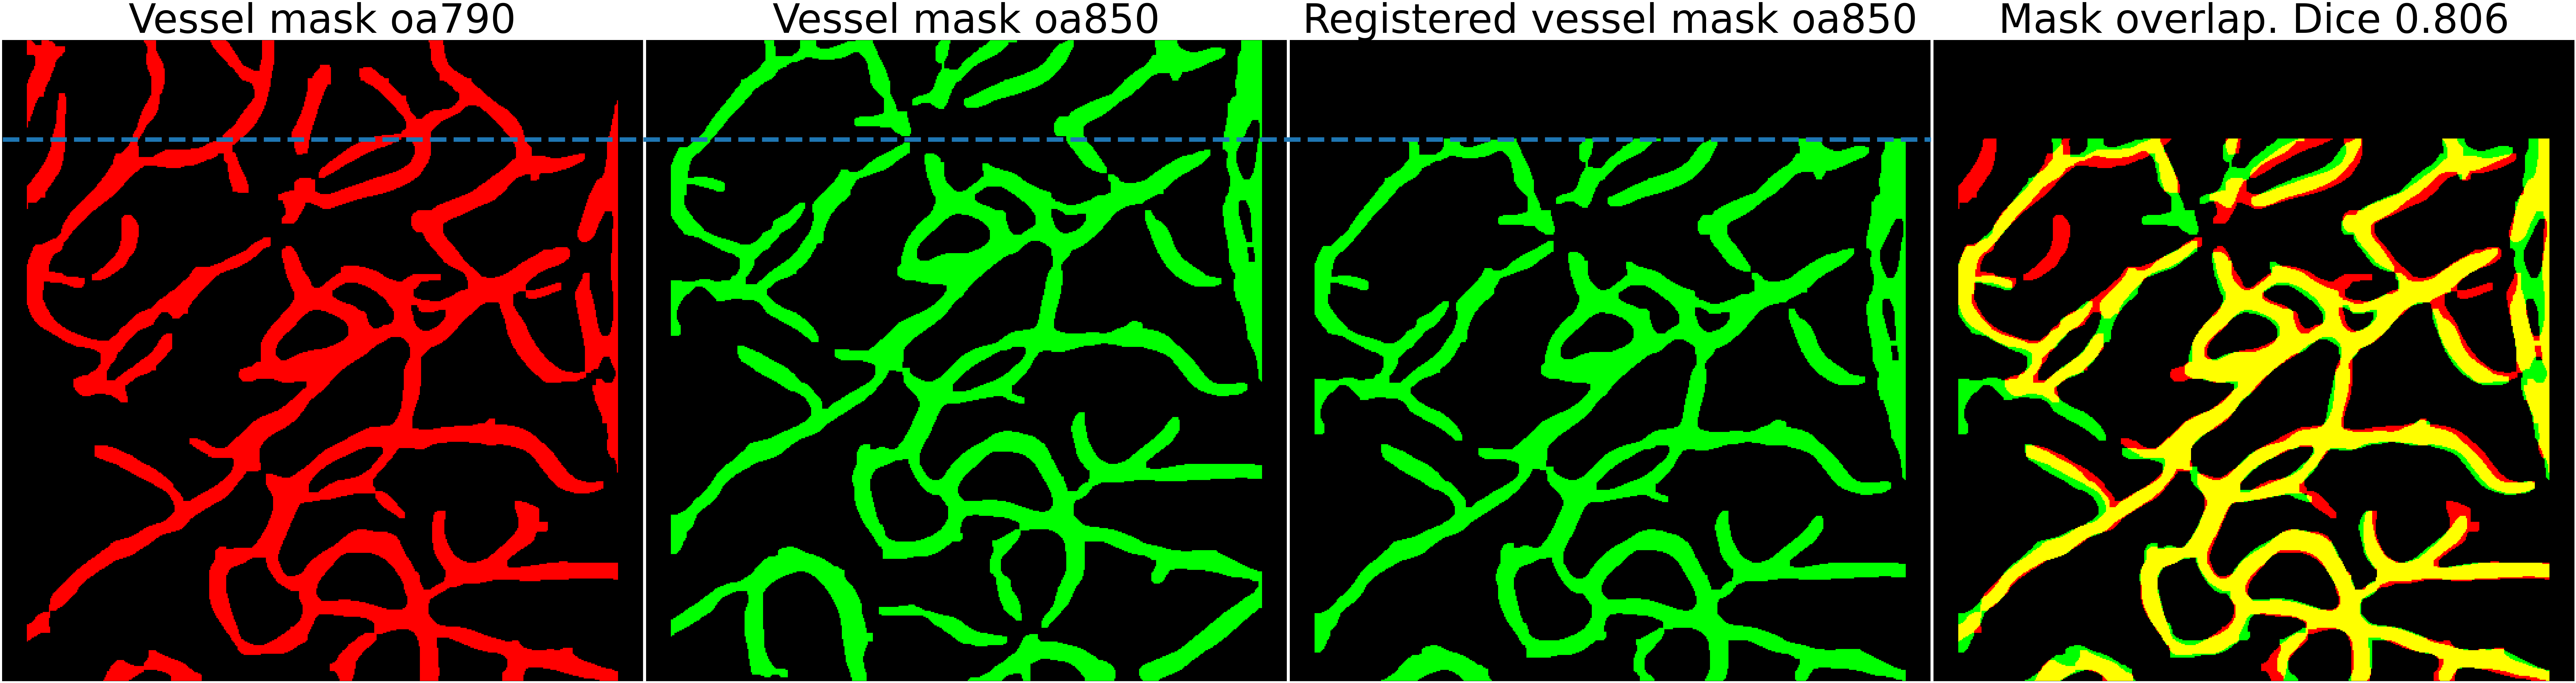

In [2]:
video_sessions = get_video_sessions(marked=True, registered=True, validation=False)
for vs in video_sessions:
    vs.load_vessel_masks(True)
    vs.visualize_registration()

### Patch classification

In [9]:
from classificationutils import SessionClassifier

balanced_accuracy =\
results.recorded_models['best_train_balanced_accuracy']['train_classification_results'].balanced_accuracy
model = results.recorded_models['best_train_balanced_accuracy']['model'].eval()

In [ ]:
print('General balanced accuracy', balanced_accuracy)
for vs in video_sessions:
    print(vs.video_file)
    vs_c = SessionClassifier(
        vs, model, **classifier_params
    )
    
    classification_results = vs_c.classify_cells()

    print(vs.basename)
    print(f'Sensitivity: {classification_results.positive_accuracy:.3f}', 
          f'Specificity: {classification_results.negative_accuracy:.3f}',
          f'Balanced acc: {classification_results.balanced_accuracy:.3f}')
    print('-----------')

### Position estimation

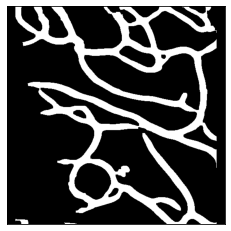

In [10]:
from guitools import CvRoipolySelector
video_sessions = get_video_sessions(marked=True, registered=True, validation=False)

vs = video_sessions[5]
roipoly_selector = CvRoipolySelector('Select segment to remove', np.uint8(vs.vessel_mask_oa790) * 255)
roipoly_selector.activate()
vs.vessel_mask_oa790 =  np.bool8(~roipoly_selector.mask * vs.vessel_mask_oa790)
plt.imshow(vs.vessel_mask_oa790)
no_ticks()

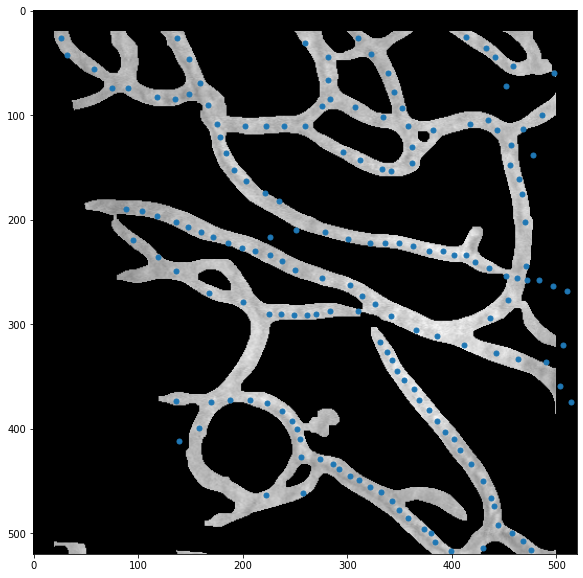

In [11]:
frame_idx = vs.validation_frame_idx

positions = vs.cell_positions[frame_idx]
masked_frame = vs.frames_oa790[frame_idx] * vs.mask_frames_oa790[frame_idx] * vs.vessel_mask_oa790

### plots ###
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(10, 10))
# no_ticks()
plt.imshow(masked_frame)
plt.scatter(positions[:, 0], positions[:, 1], s=25)
pass

In [35]:
vs_c = SessionClassifier(vs, model, **classifier_params)
estimated_locations = vs_c.estimate_locations(frame_idx, grid_search=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [02:12<00:00,  7.33s/it]


In [36]:
TP = vs_c.result_evaluations[frame_idx].n_true_positives 
FP = vs_c.result_evaluations[frame_idx].n_false_positives
FN = vs_c.result_evaluations[frame_idx].n_false_negatives

2 * TP / (2 * TP + FP + FN)

0.8071428571428572

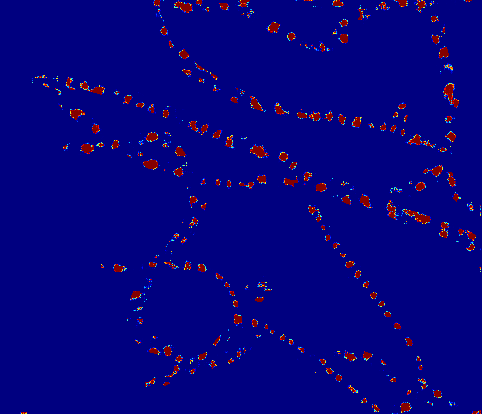

In [38]:
pm = vs_c.probability_maps[frame_idx]
pm = np.uint8(pm * 255)
pm = cv2.applyColorMap(pm, cv2.COLORMAP_JET)
pm = cv2.cvtColor(pm, cv2.COLOR_BGR2RGB)

from patchextraction import get_mask_bounds
x_min, x_max, y_min, y_max = get_mask_bounds(vs.registered_mask_frames_oa850[frame_idx])
pm = pm[y_min:y_max, x_min:x_max]
import PIL.Image
image = PIL.Image.fromarray(pm)
image.save(os.path.join(report_images_folder, f'{vs.basename}_prob_map.png'))

image

In [12]:
evaluation = vs_c.result_evaluations[vs.validation_frame_idx]
s = evaluation.sigma
H = evaluation.extended_maxima_h
T = evaluation.region_max_threshold
print(f's: {s:.3f}')
print(f'H: {H:.3f}')
print(f'T: {T:.3f}')
from classificationutils import RegionCoordSelectMode

KeyError: 211

In [22]:
from plotutils import savefig_tight

In [14]:
from classificationutils import SessionClassifier
vs_c = SessionClassifier(vs, model, **classifier_params)
estimated_locations = vs_c.estimate_locations(frame_idx, grid_search=False)

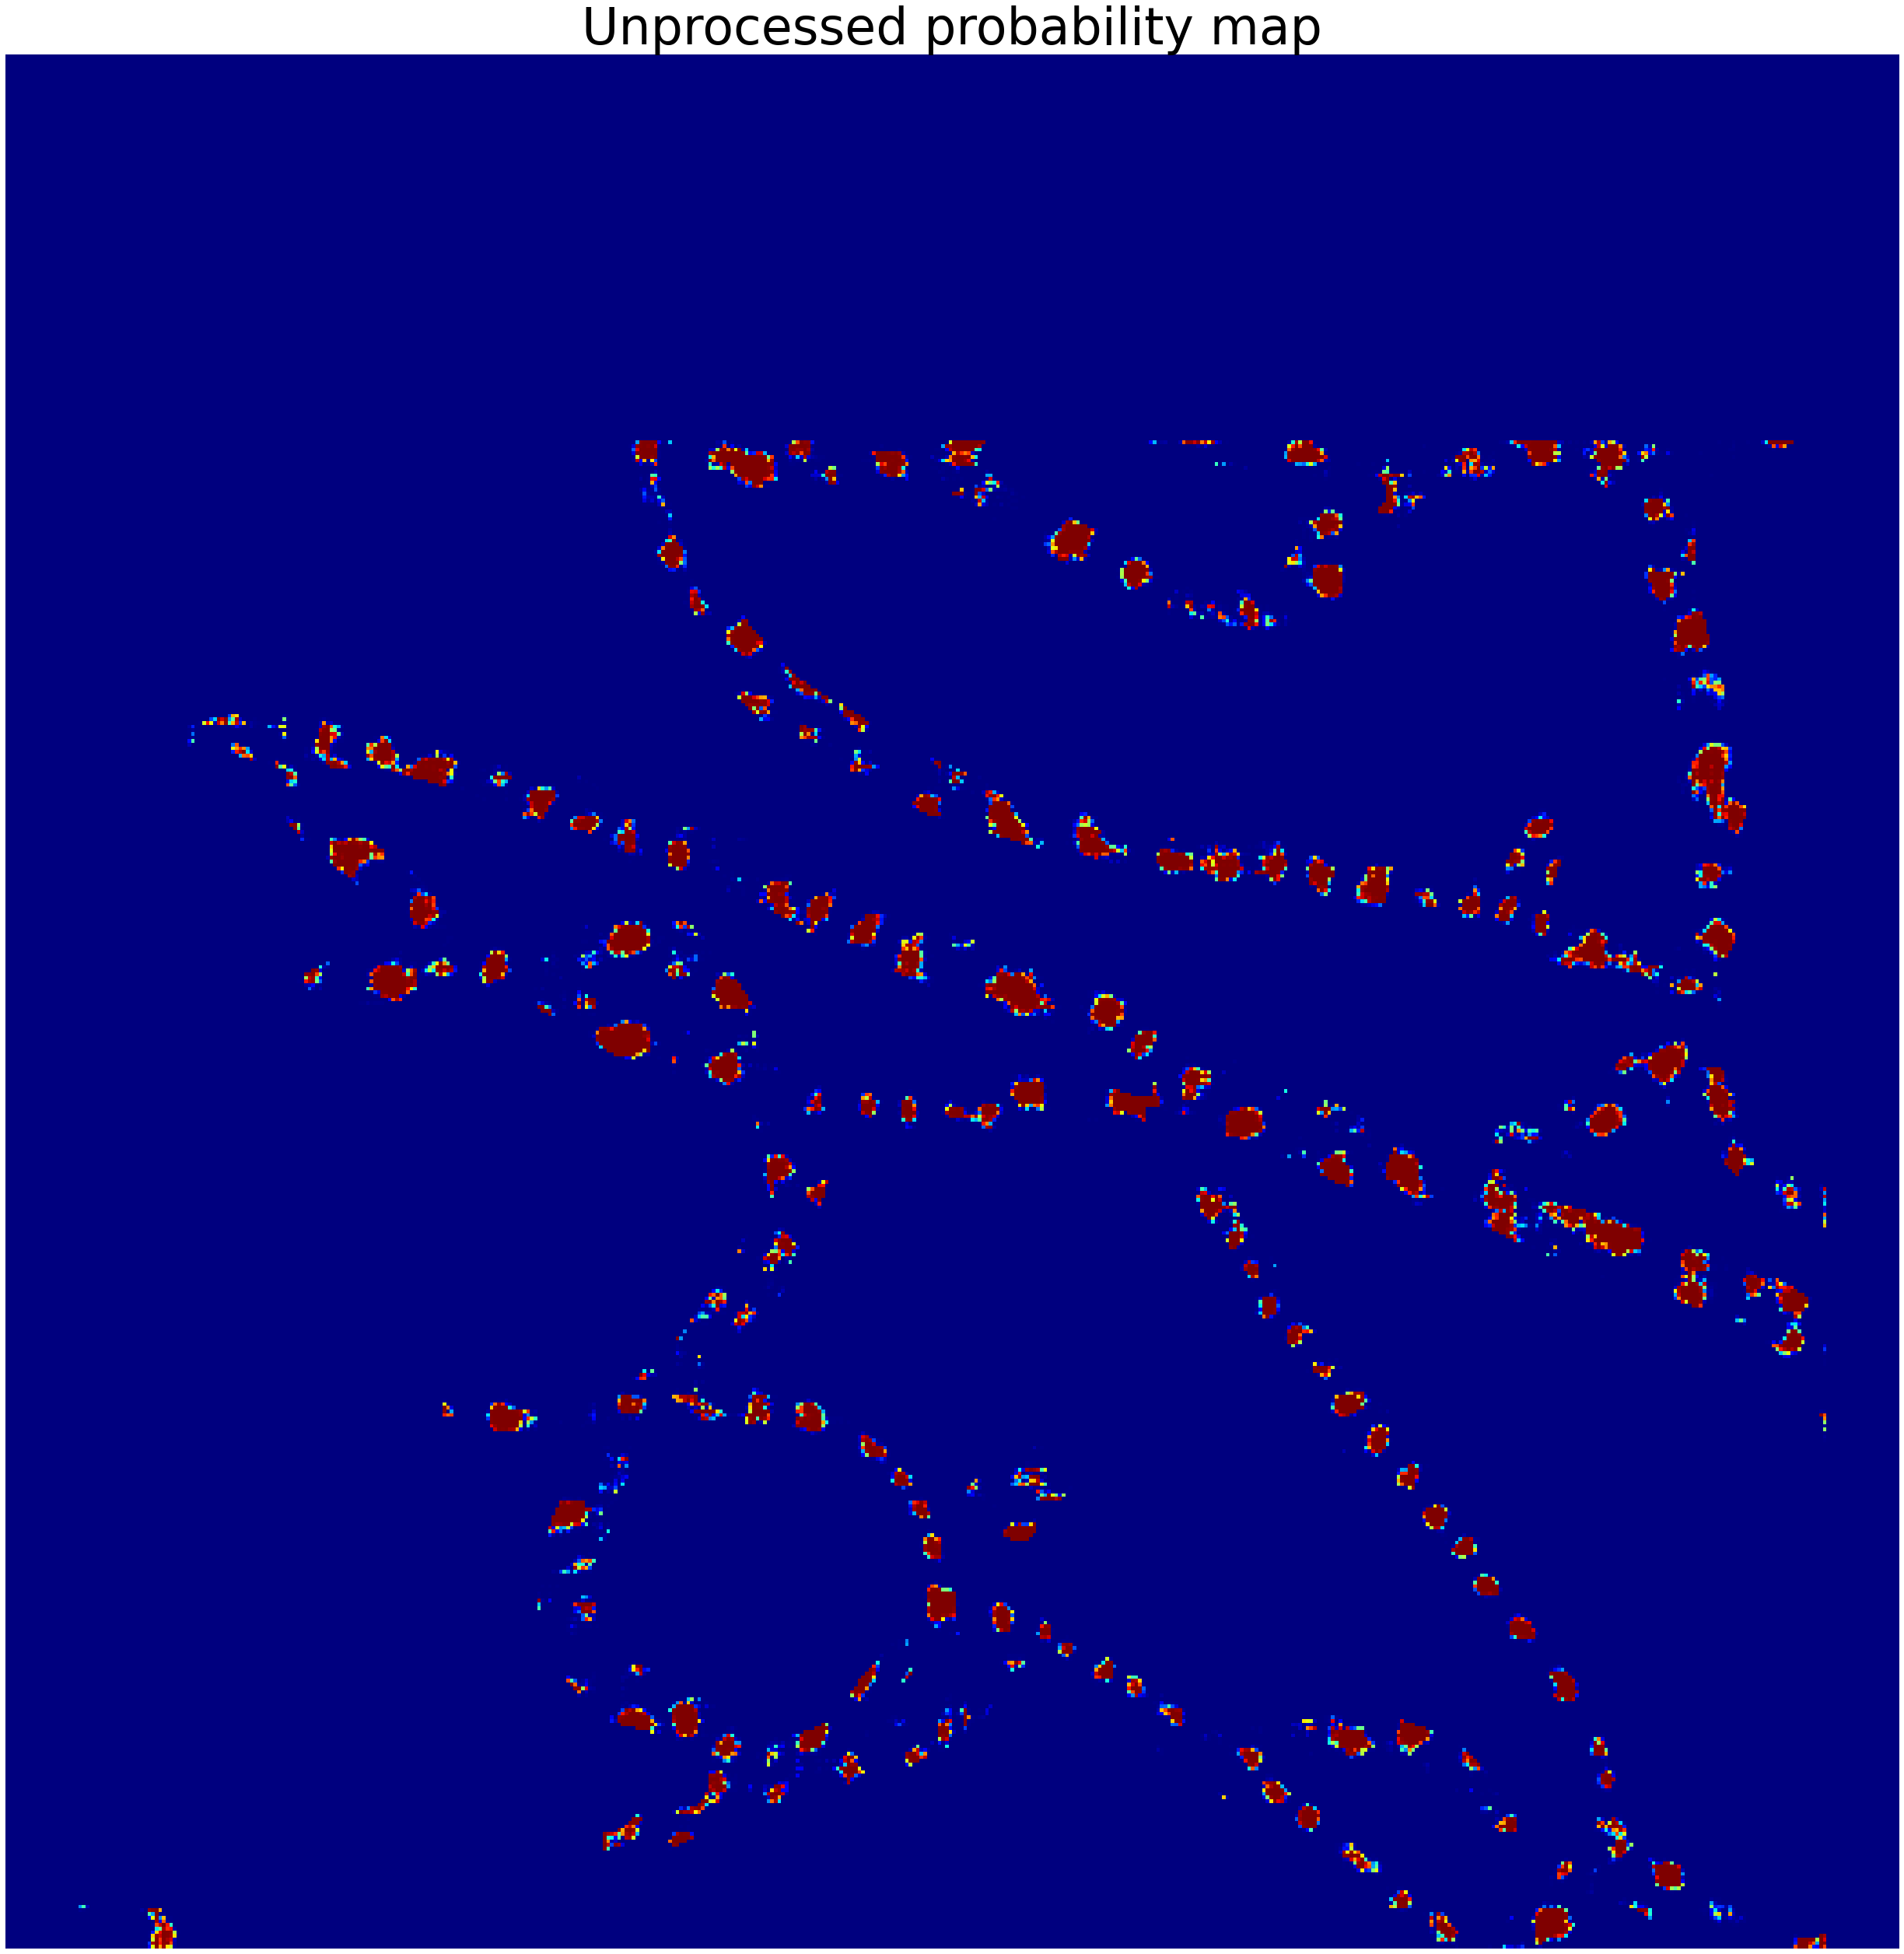

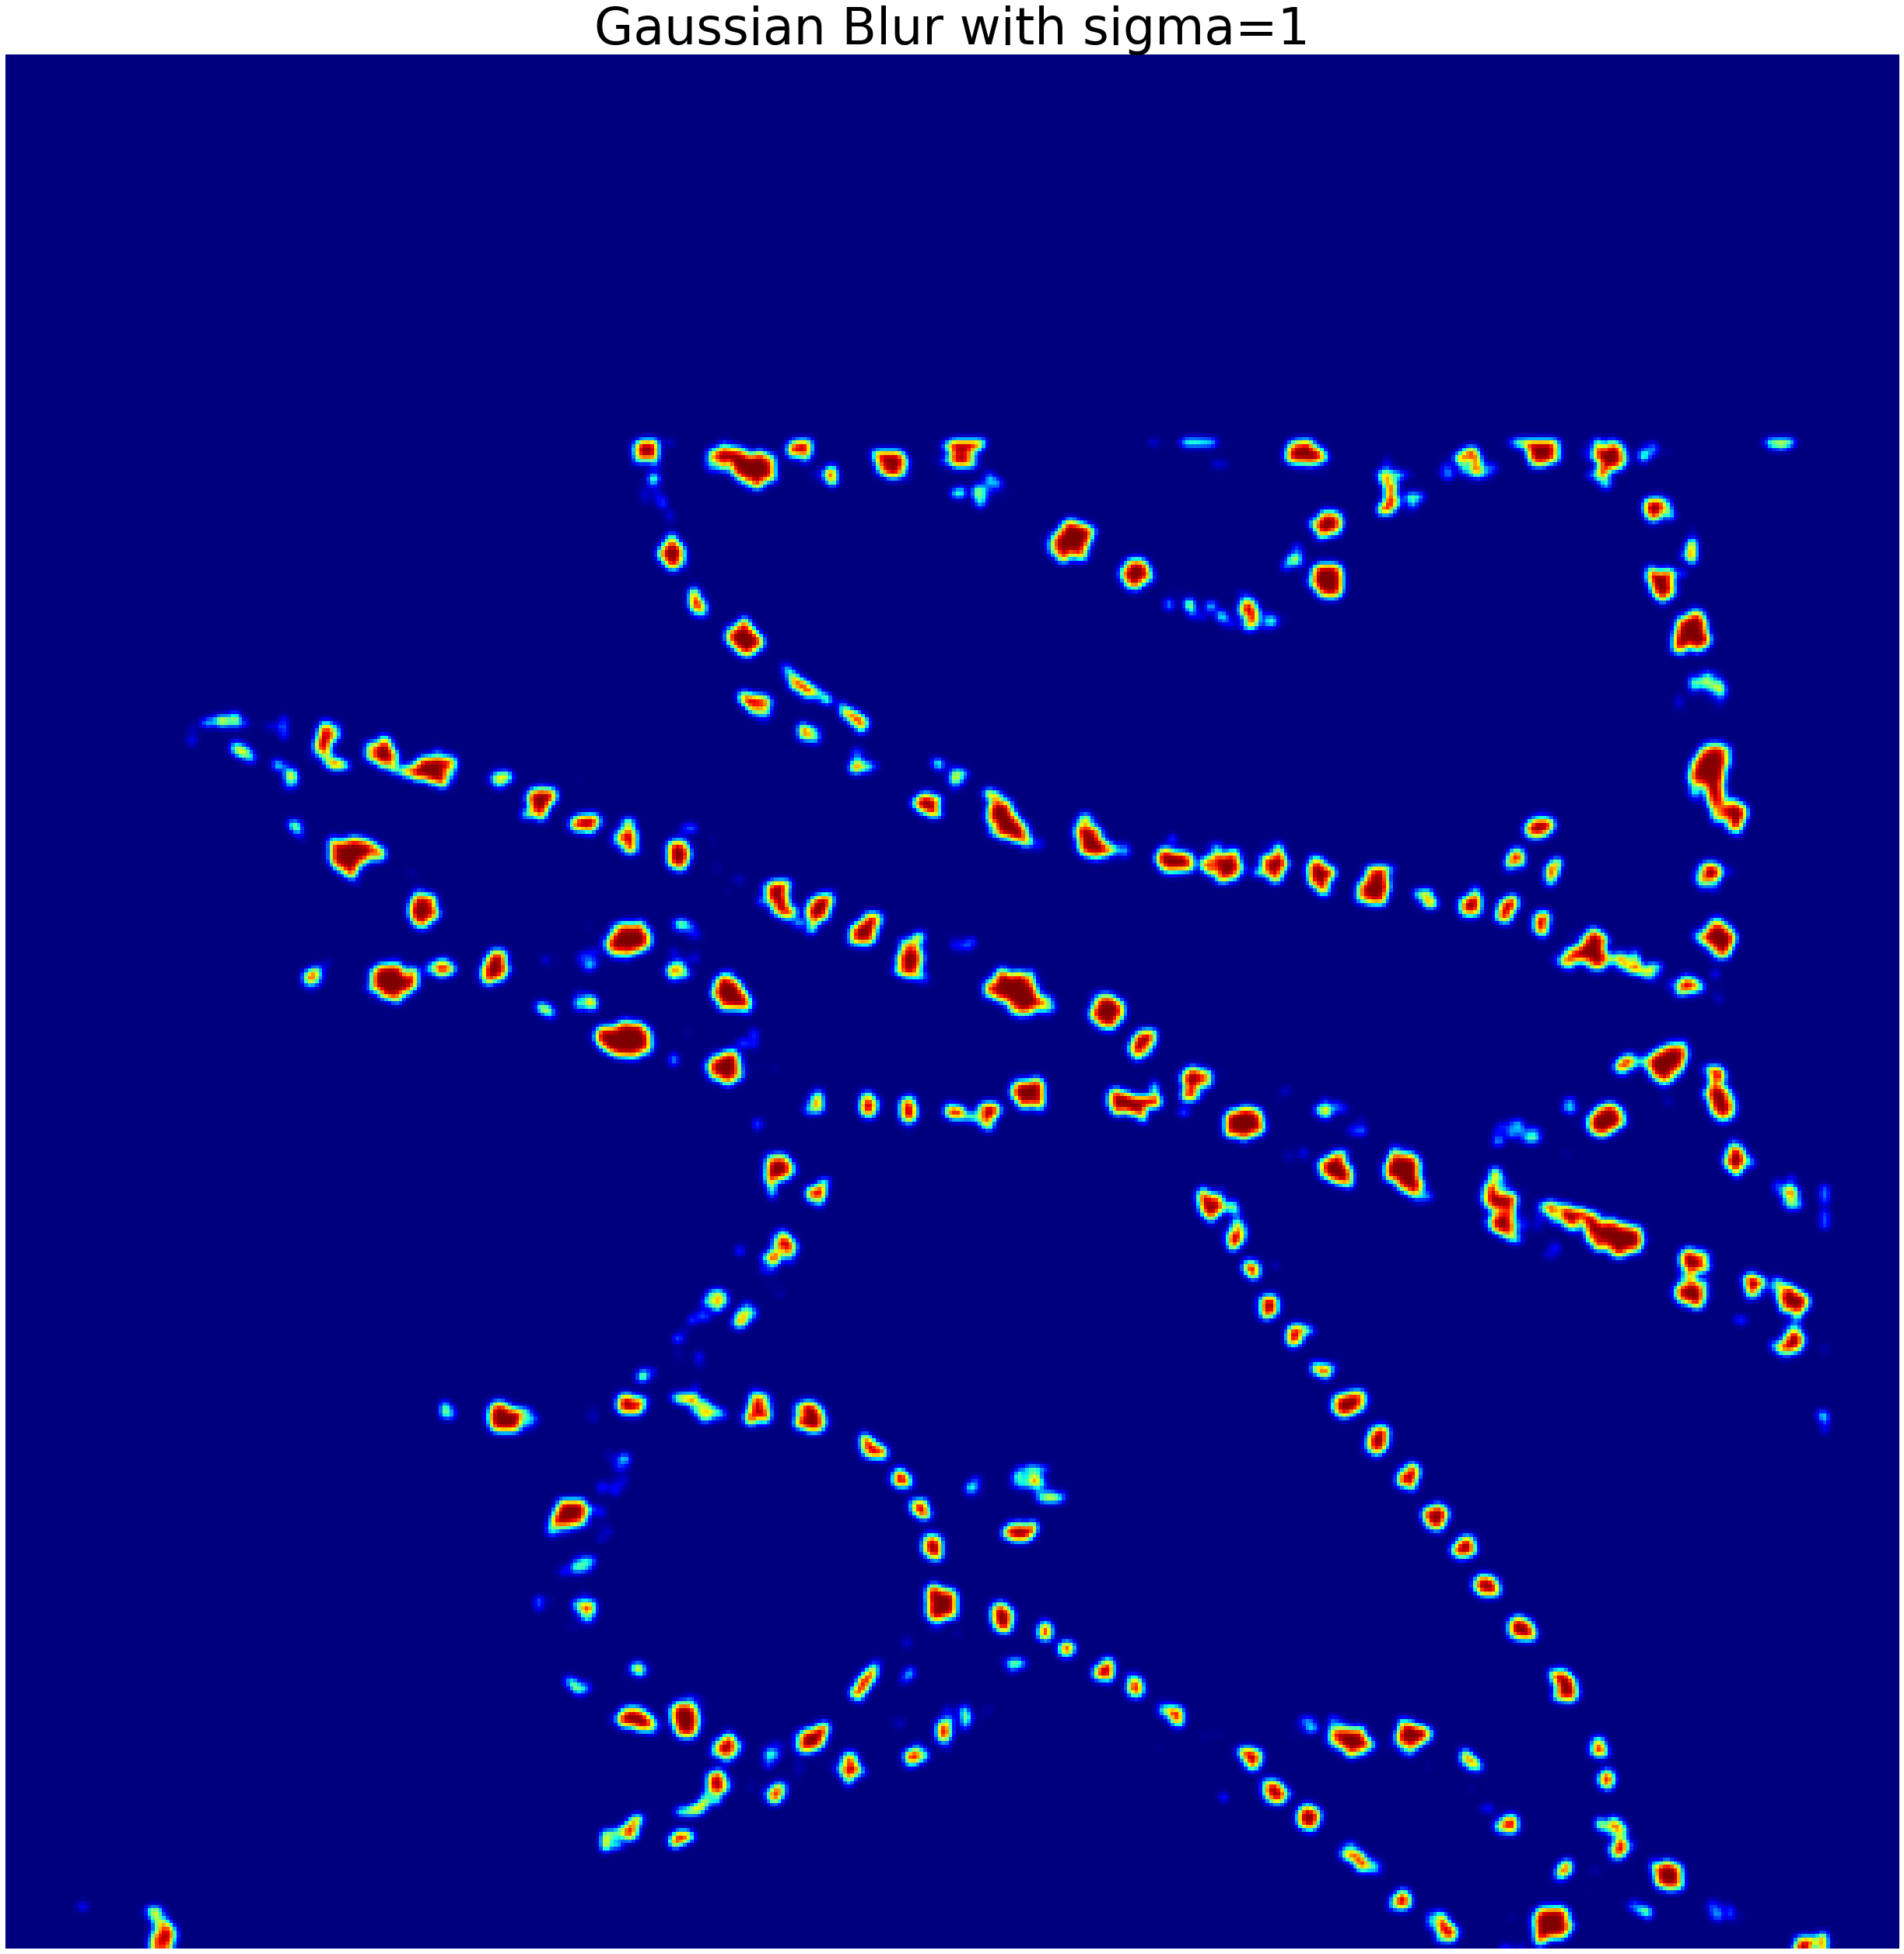

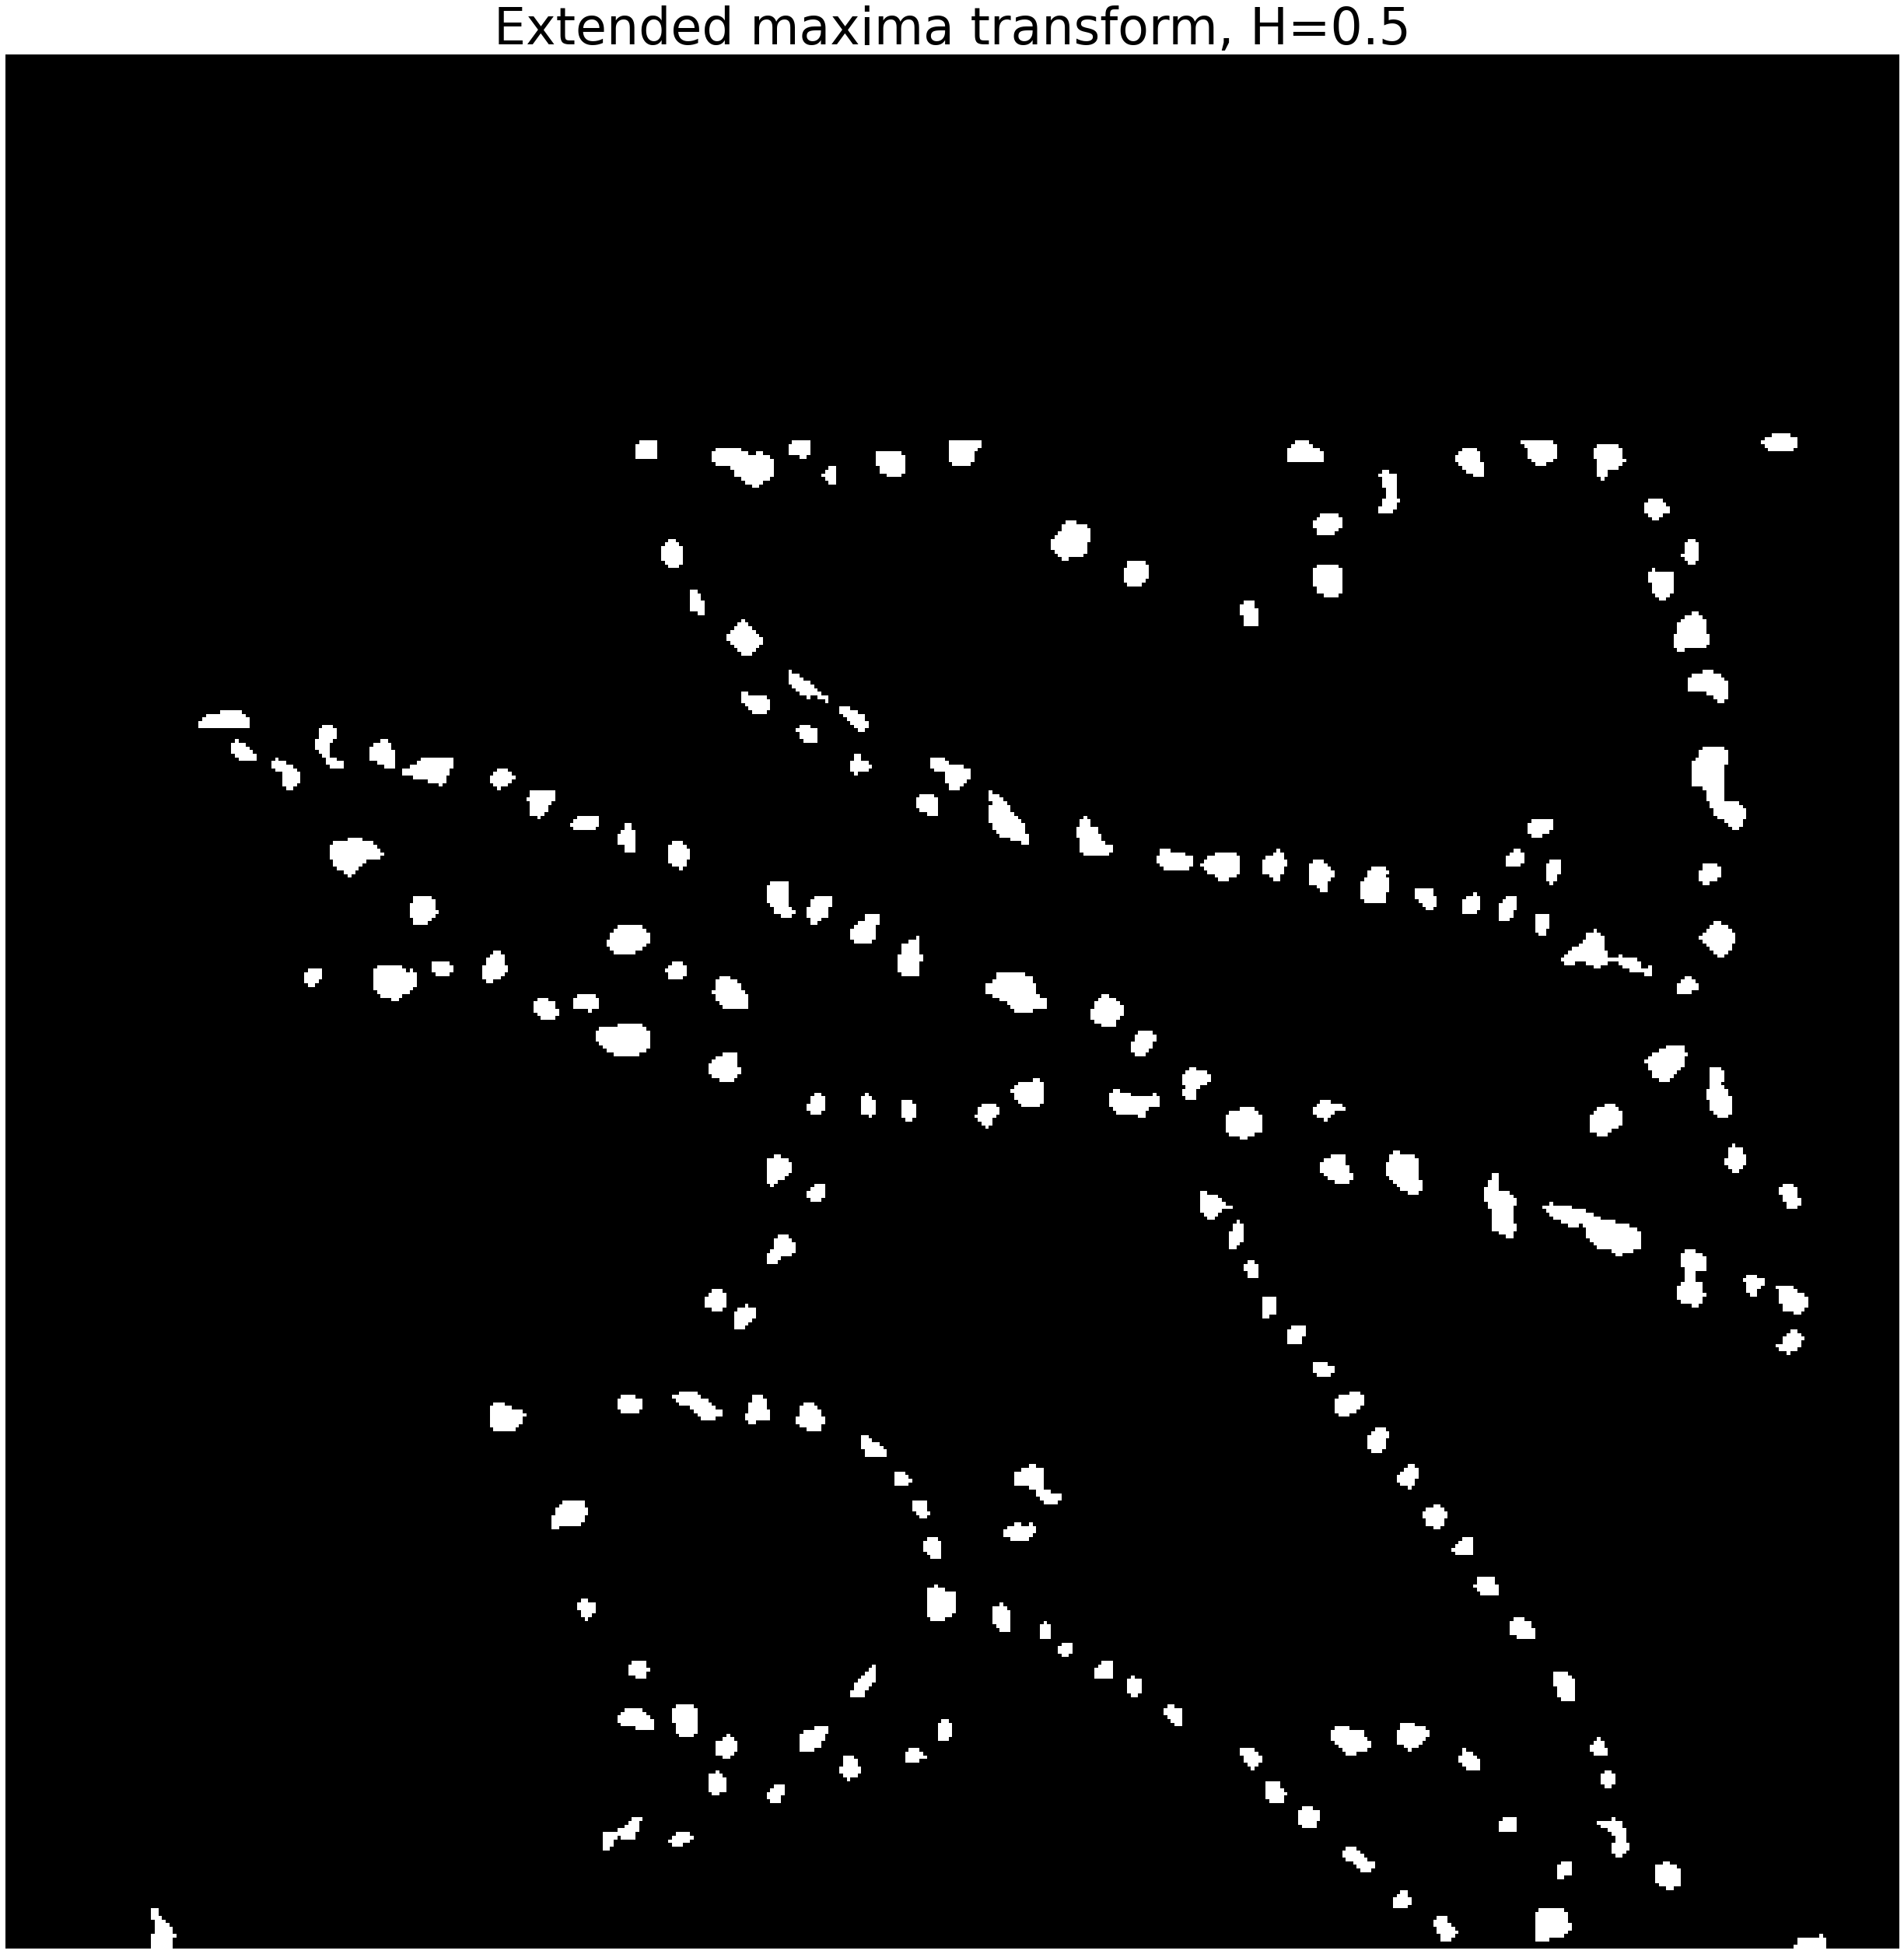

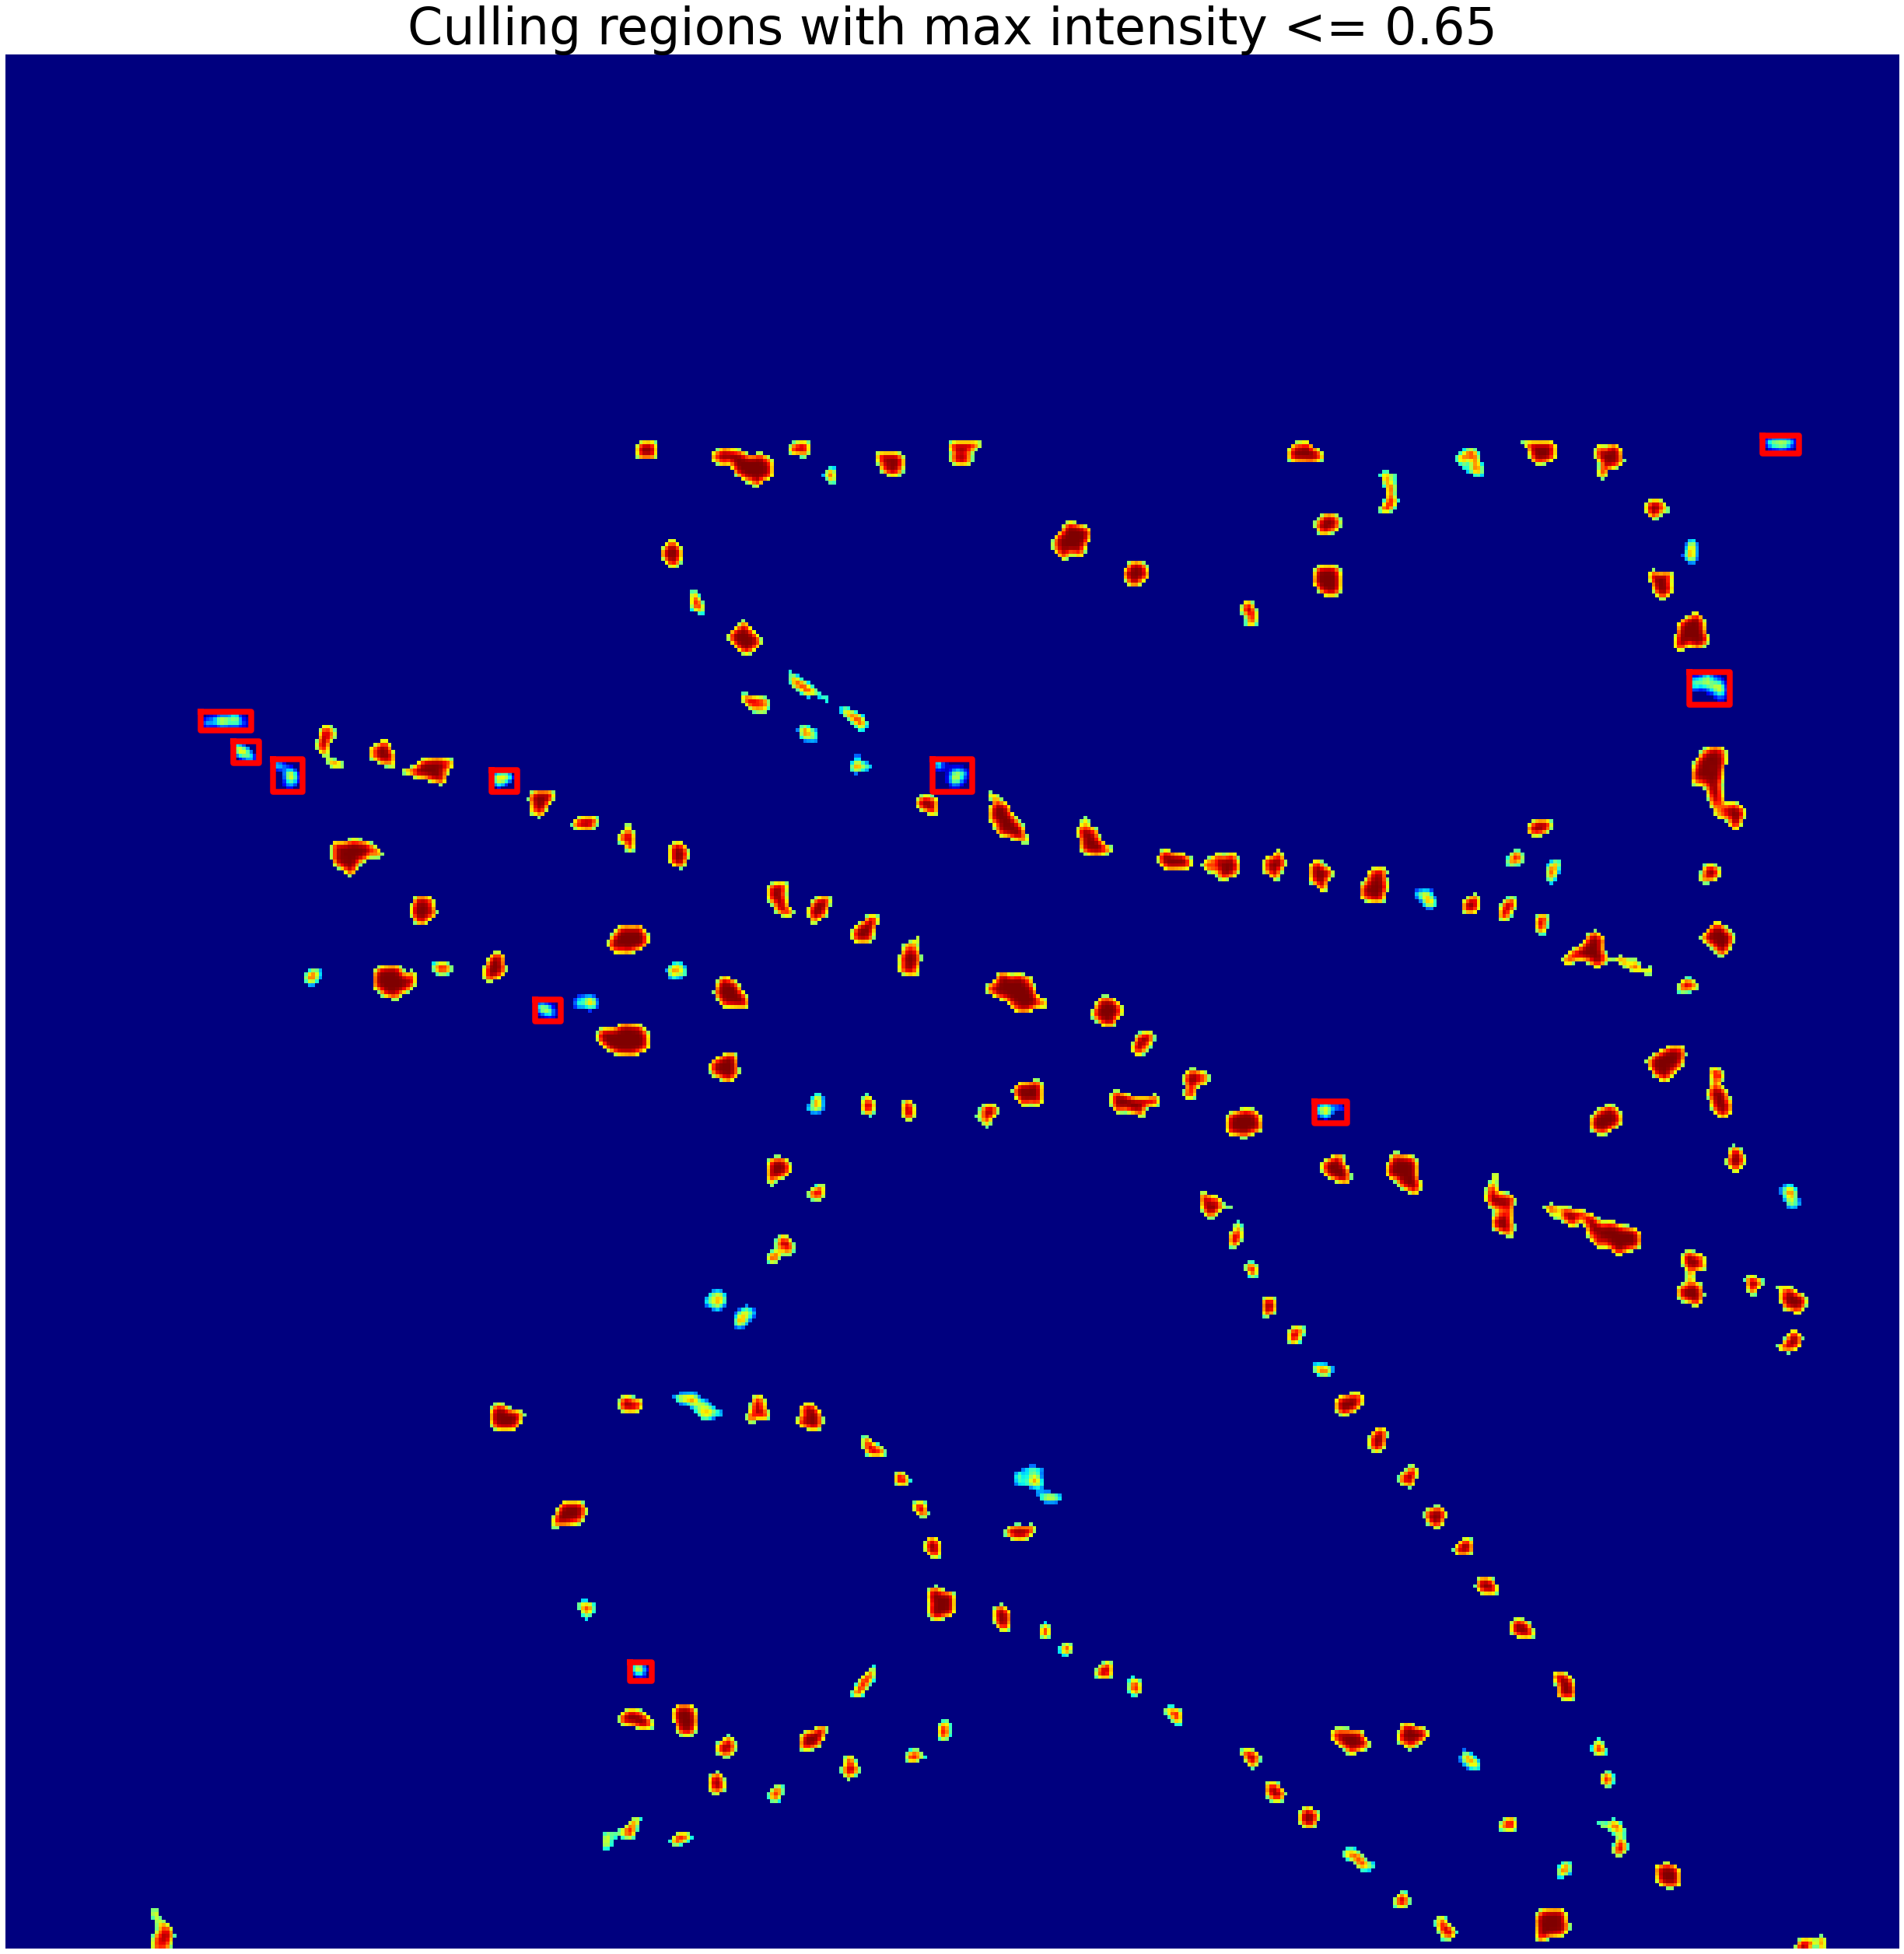

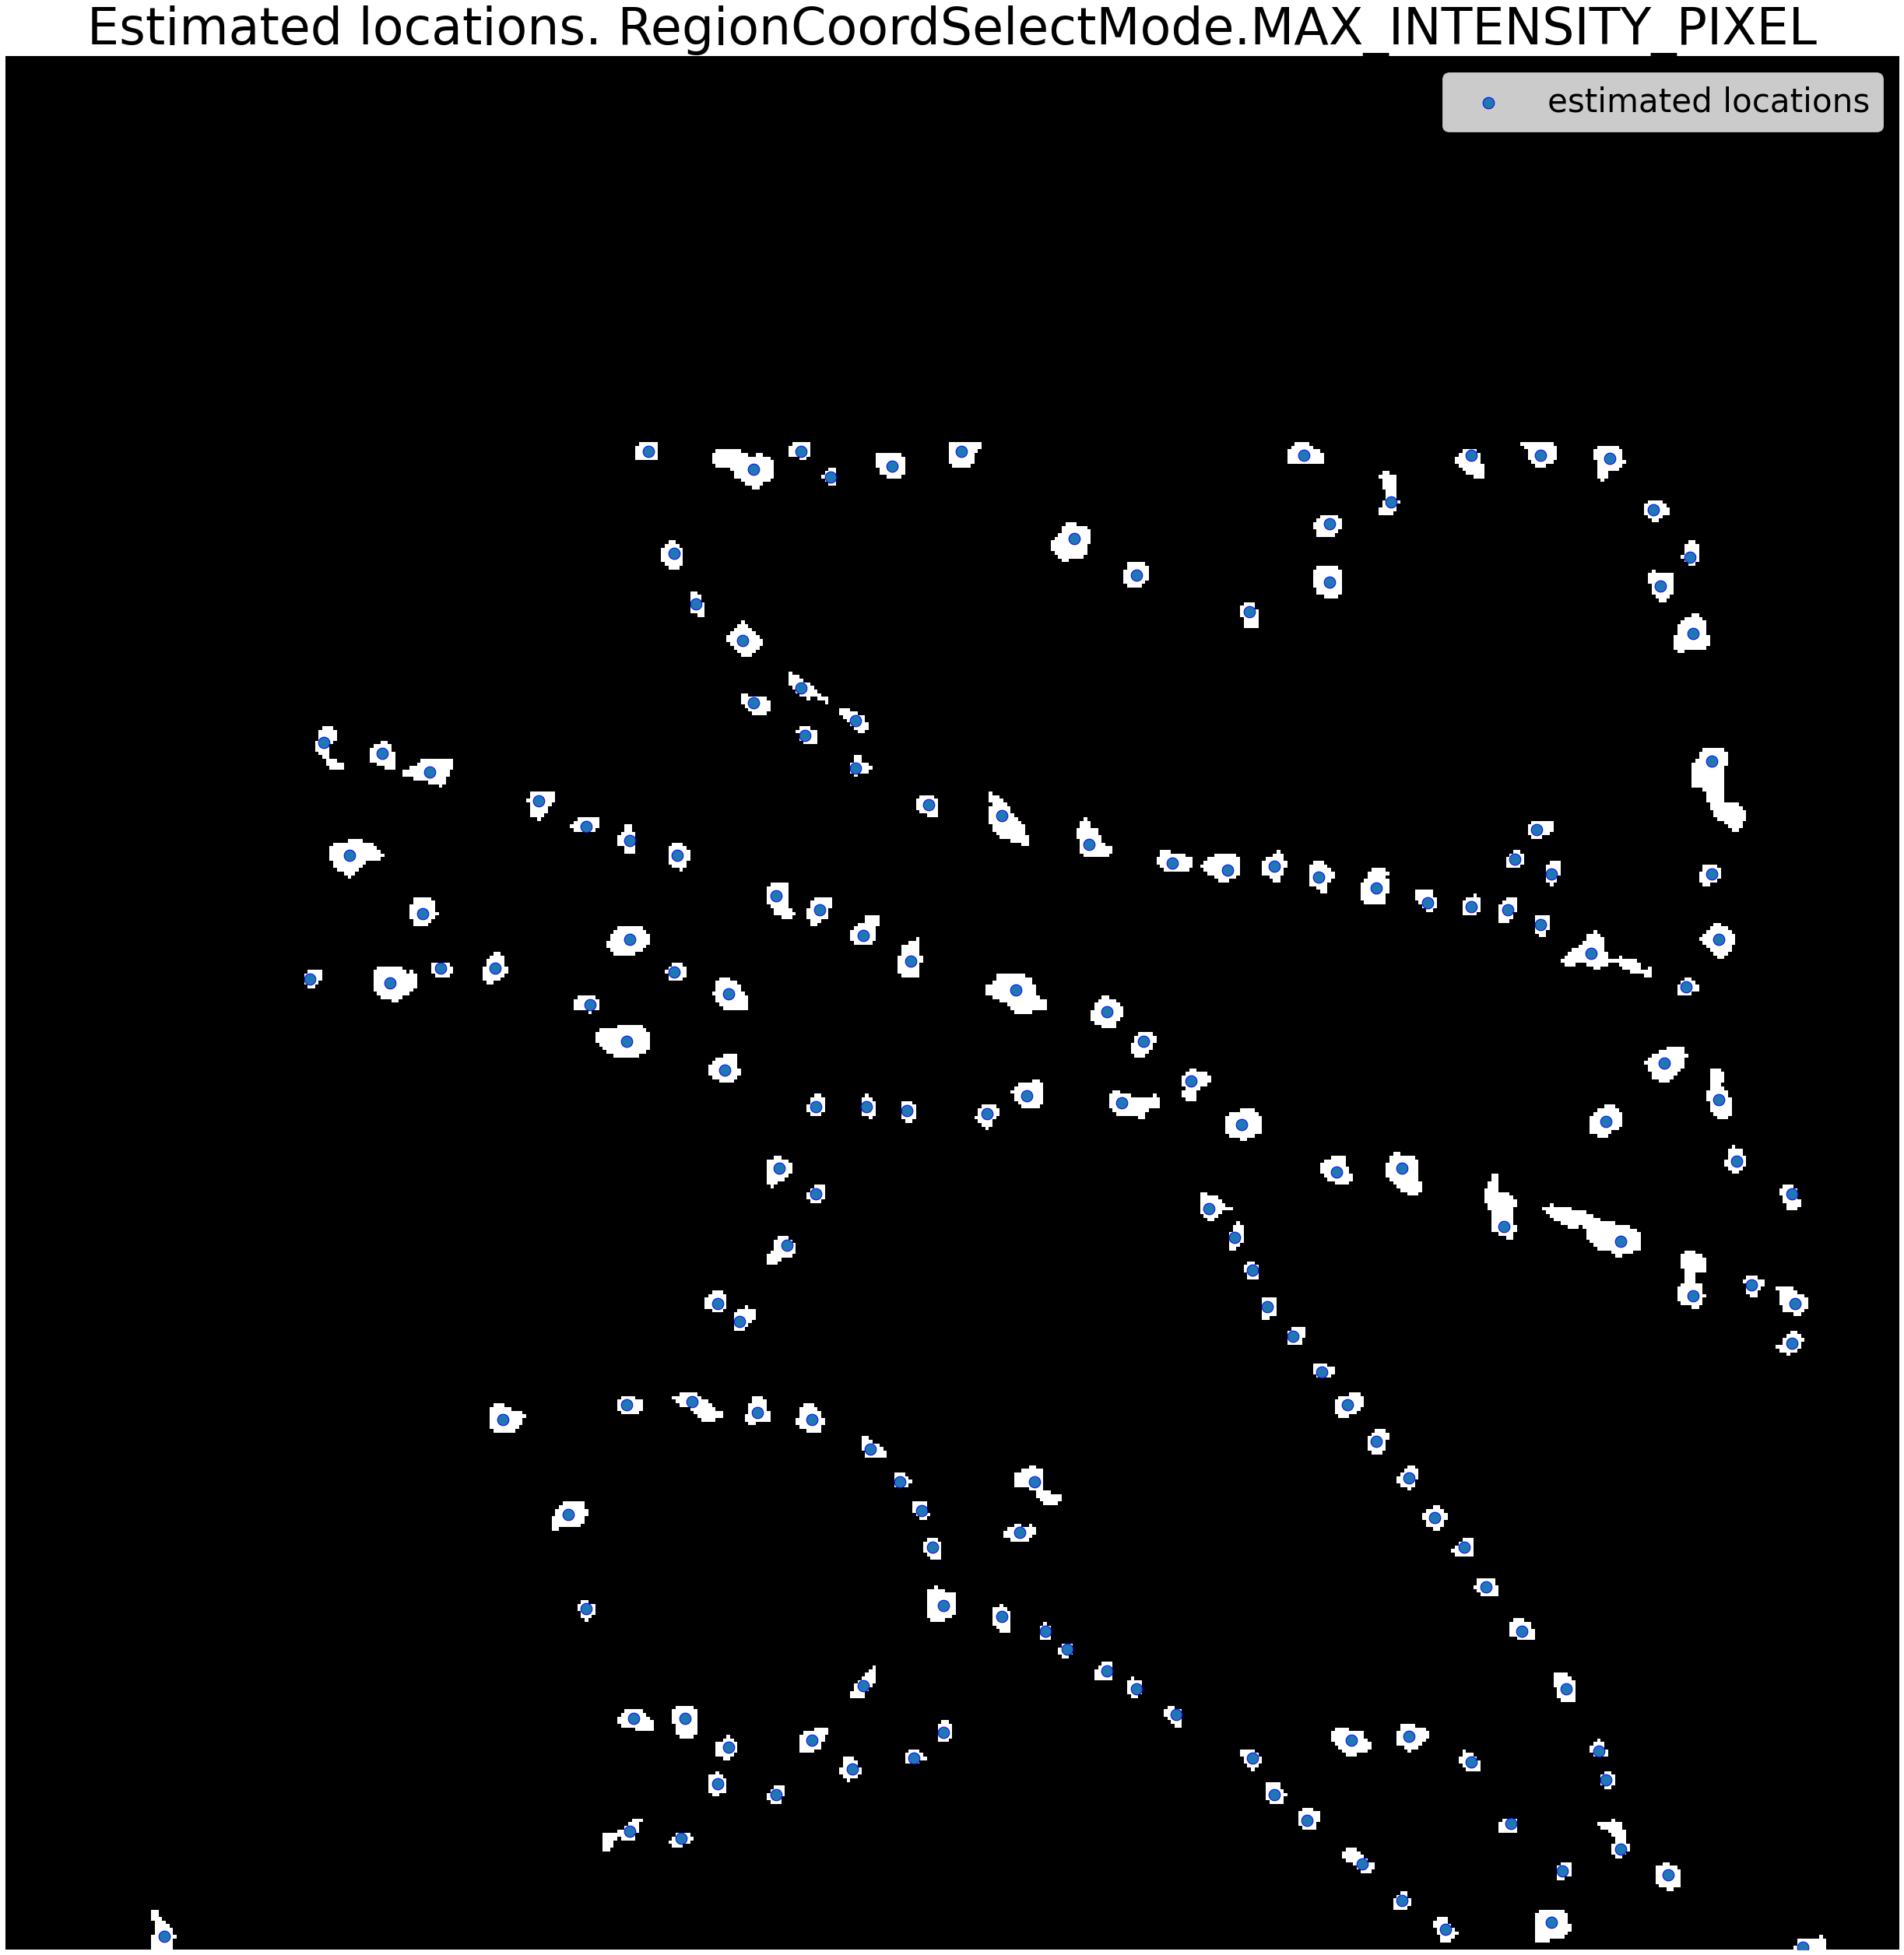

In [58]:
from classificationutils import estimate_cell_positions_from_probability_map

estimated_locations = estimate_cell_positions_from_probability_map(
    vs_c.probability_maps[frame_idx], 
    extended_maxima_h=0.5,
    region_max_threshold=0.65,
    visualise_intermediate_results=True, name=os.path.join(report_images_folder, f'{vs.basename}_prob_map_binarisation')
)

In [57]:
from classificationutils import RegionCoordSelectMode
str(RegionCoordSelectMode.GEOMETRIC_CENTROID)

'RegionCoordSelectMode.GEOMETRIC_CENTROID'

# Performance on validation data

### Performance on patch classification

Loaded .\data\validation\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped_vessel_mask.png
Loaded .\data\validation\Subject3_Session216_OD_(0,0)_1x1_980_OA850nm1_extract_reg_cropped_vessel_mask.png
Loaded .\data\validation\Subject3_Session216_OD_(0,0)_1x1_980_Confocal1_extract_reg_cropped_vessel_mask.png
Loaded .\data\validation\Subject51_Session402_OD_(0,-1)_1.04x1.04_3416_OA790nm1_extract_reg_cropped_vessel_mask.png
Loaded .\data\validation\Subject51_Session402_OD_(0,-1)_1.04x1.04_3416_OA850nm1_extract_reg_cropped_vessel_mask.png
Loaded .\data\validation\Subject51_Session402_OD_(0,-1)_1.04x1.04_3416_Confocal1_extract_reg_cropped_vessel_mask.png


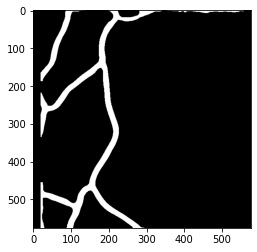

In [52]:
validation_video_sessions = get_video_sessions(marked=True, registered=True, validation=True)

[vs.load_vessel_masks(True) for vs in validation_video_sessions]
plt.imshow(validation_video_sessions[0].vessel_mask_oa790)

Loaded .\data\validation\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped_vessel_mask.png
Loaded .\data\validation\Subject3_Session216_OD_(0,0)_1x1_980_OA850nm1_extract_reg_cropped_vessel_mask.png
Loaded .\data\validation\Subject3_Session216_OD_(0,0)_1x1_980_Confocal1_extract_reg_cropped_vessel_mask.png
1599339925.1011708
2.373961925506592
Loaded .\data\validation\Subject51_Session402_OD_(0,-1)_1.04x1.04_3416_OA790nm1_extract_reg_cropped_vessel_mask.png
Loaded .\data\validation\Subject51_Session402_OD_(0,-1)_1.04x1.04_3416_OA850nm1_extract_reg_cropped_vessel_mask.png
Loaded .\data\validation\Subject51_Session402_OD_(0,-1)_1.04x1.04_3416_Confocal1_extract_reg_cropped_vessel_mask.png
1599339929.1061354
2.2289998531341553


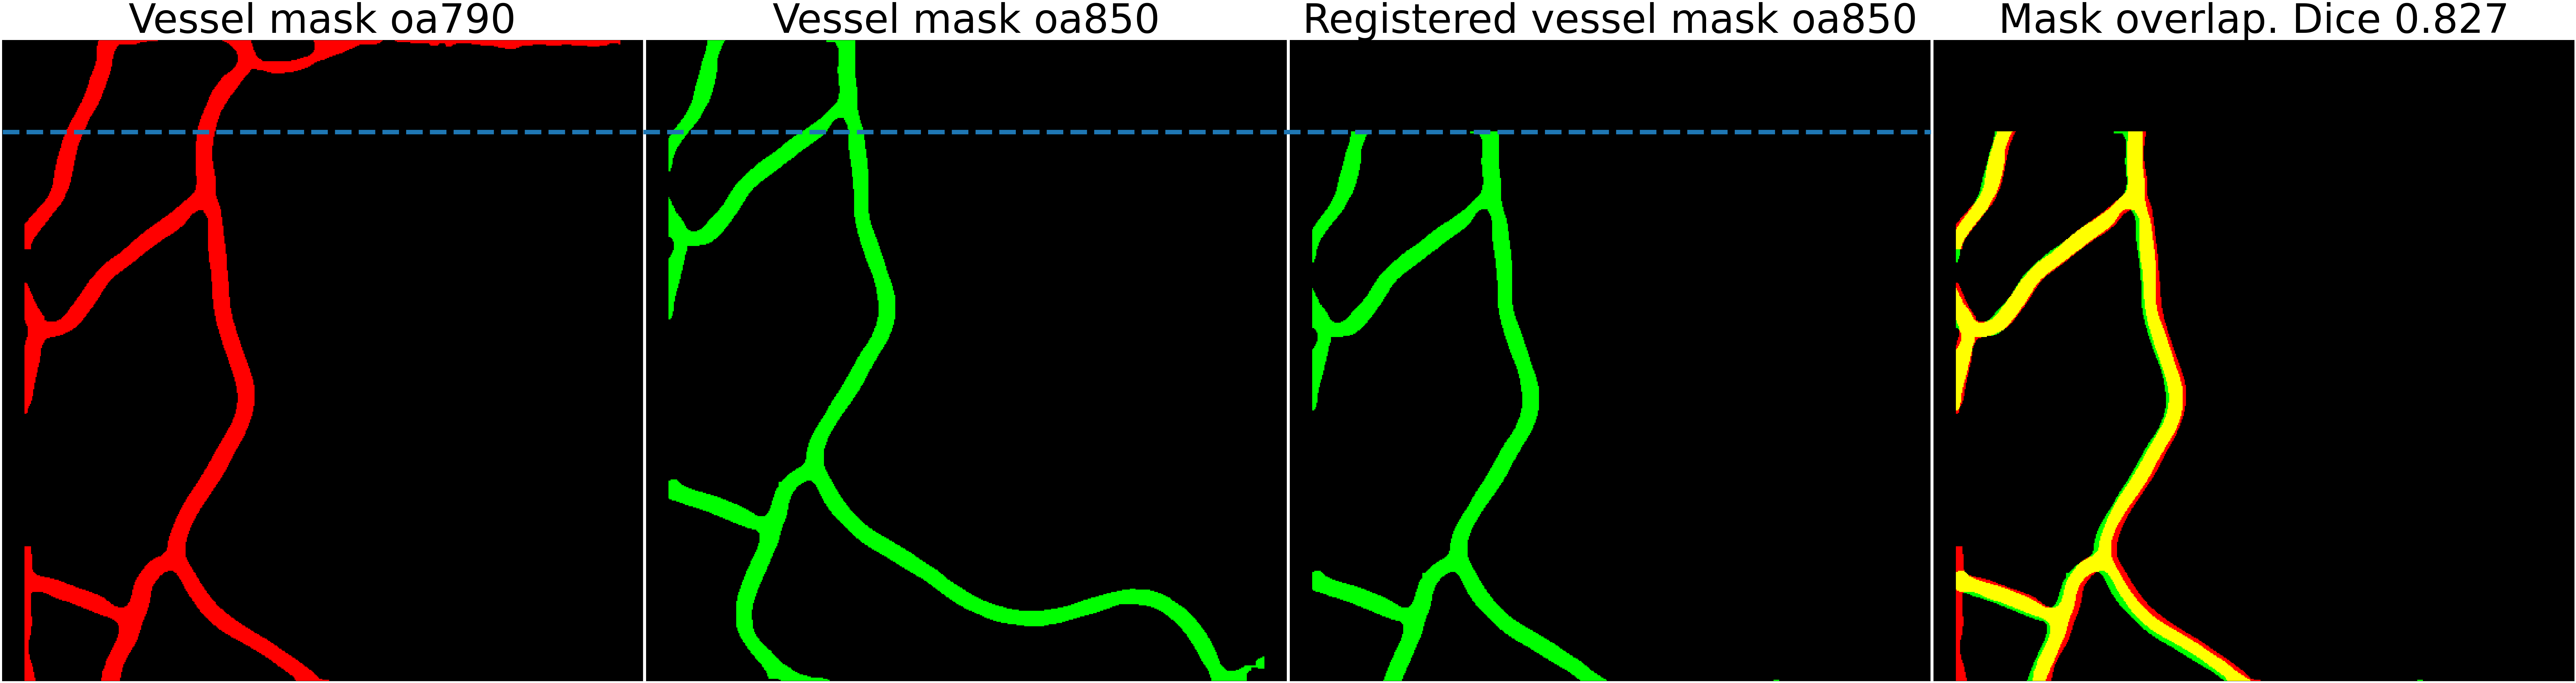

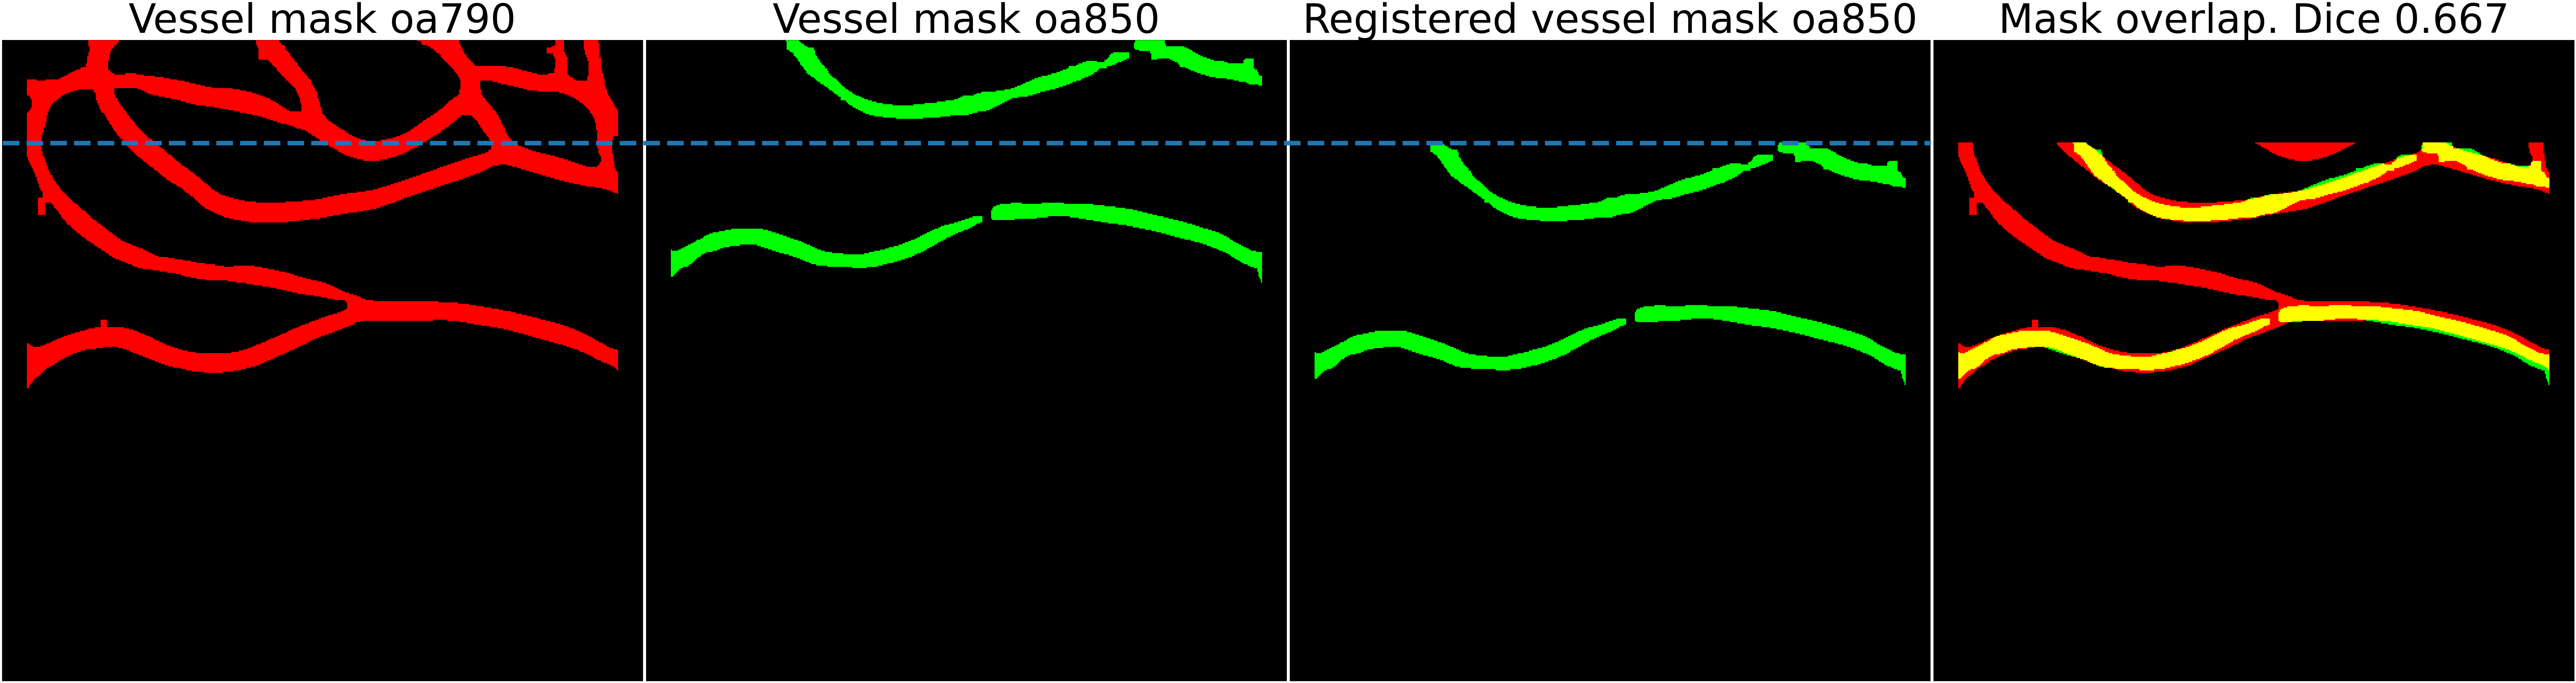

In [54]:
validation_video_sessions = get_video_sessions(marked=True, registered=True, validation=True)

for vs in validation_video_sessions:
    vs.load_vessel_masks(True)
    vs.visualize_registration()

In [42]:
from classificationutils import SessionClassifier

balanced_accuracy =\
results.recorded_models['best_valid_balanced_accuracy']['valid_classification_results'].balanced_accuracy
model = results.recorded_models['best_valid_balanced_accuracy']['model'].eval()

print('General balanced accuracy', balanced_accuracy)
for vs in validation_video_sessions:
    vs_c = SessionClassifier(vs, model, **classifier_params)
    classification_results = vs_c.classify_cells()
    print(vs.basename)
    print(f'Sensitivity: {classification_results.positive_accuracy:.3f}', 
          f'Specificity: {classification_results.negative_accuracy:.3f}',
          f'Balanced acc: {classification_results.balanced_accuracy:.3f}')
    print('-----------')

General balanced accuracy 0.8374299133082639
Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped
Sensitivity: 0.815 Specificity: 0.863 Balanced acc: 0.839
-----------
Subject51_Session402_OD_(0,-1)_1.04x1.04_3416_OA790nm1_extract_reg_cropped
Sensitivity: 0.752 Specificity: 0.752 Balanced acc: 0.752
-----------


### Position estimation

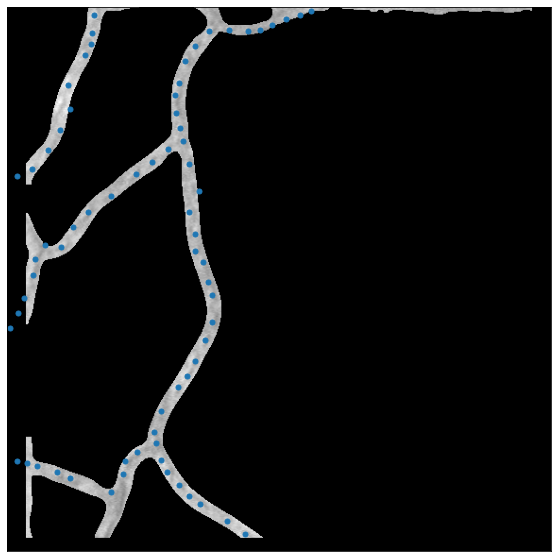

In [43]:
vs = validation_video_sessions[0]
frame_idx = vs.validation_frame_idx

positions = vs.cell_positions[frame_idx]
masked_frame = vs.frames_oa790[frame_idx] * vs.vessel_mask_oa790 * vs.mask_frames_oa790[frame_idx]

### plots #### 
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(10, 10))
no_ticks()
plt.imshow(masked_frame)
plt.scatter(positions[:, 0], positions[:, 1], s=25)
pass

In [44]:
vs = validation_video_sessions[0]
vs_c = SessionClassifier(vs, model, **classifier_params)
estimated_locations = vs_c.estimate_locations(frame_idx, grid_search=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [02:15<00:00,  7.54s/it]


In [ ]:
plt.rcParams['axes.titlesize'] = 50
vs_c.result_evaluations[frame_idx].visualize()
plt.savefig(f'/mnt/large/tom/{vs.basename}_valid_evaluation_results.png')

In [ ]:
evaluation = vs_c.result_evaluations[vs.validation_frame_idx]
s = evaluation.sigma
H = evaluation.extended_maxima_h
T = evaluation.region_max_threshold
print(f's: {s:.3f}')
print(f'H: {H:.3f}')
print(f'T: {T:.3f}')
from classificationutils import RegionCoordSelectMode

In [ ]:
frame_idx = vs.validation_frame_idx
estimated_locations = vs_c.estimate_locations(
    frame_idx, grid_search=False,
    region_coord_select_mode=RegionCoordSelectMode.GEOMETRIC_CENTROID,
    use_vessel_mask=False,
    sigma=s, extended_maxima_h=H, region_max_threshold=T)
vs_c.result_evaluations[frame_idx].visualize()

In [ ]:
frame_idx = vs.validation_frame_idx

pm = vs_c.probability_maps[frame_idx]
pm = np.uint8(pm * 255)
pm = cv2.applyColorMap(pm, cv2.COLORMAP_JET)
pm = cv2.cvtColor(pm, cv2.COLOR_BGR2RGB)

from patchextraction import get_mask_bounds
import PIL.Image
x_min, x_max, y_min, y_max = get_mask_bounds(vs.registered_mask_frames_oa850[frame_idx])
pm = pm[y_min:y_max, x_min:x_max]

PIL.Image.fromarray(pm).save(os.path.join(
    report_images_folder, f'{vs.basename}no_vessel_mask_valid_prob_map.png'
))
PIL.Image.fromarray(pm)

In [ ]:
frame_idx = vs.validation_frame_idx
estimated_locations = vs_c.estimate_locations(
    frame_idx, grid_search=False,
    region_coord_select_mode=RegionCoordSelectMode.GEOMETRIC_CENTROID,
    sigma=s, extended_maxima_h=H, region_max_threshold=T)
vs_c.result_evaluations[frame_idx].visualize()

In [ ]:
frame_idx = vs.validation_frame_idx
estimated_locations = vs_c.estimate_locations(
    frame_idx, grid_search=False,
    region_coord_select_mode=RegionCoordSelectMode.MAX_INTENSITY_PIXEL,
    sigma=s, extended_maxima_h=H, region_max_threshold=T)
vs_c.result_evaluations[frame_idx].visualize()

In [ ]:
frame_idx = vs.validation_frame_idx
estimated_locations = vs_c.estimate_locations(
    frame_idx, grid_search=False,
    region_coord_select_mode=RegionCoordSelectMode.WEIGHTED_CENTROID,
    sigma=s, extended_maxima_h=H, region_max_threshold=T)
vs_c.result_evaluations[frame_idx].visualize()

In [ ]:
frame_idx = vs.validation_frame_idx

pm = vs_c.probability_maps[frame_idx]
pm = np.uint8(pm * 255)
pm = cv2.applyColorMap(pm, cv2.COLORMAP_JET)
pm = cv2.cvtColor(pm, cv2.COLOR_BGR2RGB)

from patchextraction import get_mask_bounds
import PIL.Image
x_min, x_max, y_min, y_max = get_mask_bounds(vs.registered_mask_frames_oa850[frame_idx])
pm = pm[y_min:y_max, x_min:x_max]

PIL.Image.fromarray(pm).save(os.path.join(
    report_images_folder, f'{vs.basename}_valid_prob_map.png'
))
PIL.Image.fromarray(pm)

In [ ]:
from classificationutils import estimate_cell_positions_from_probability_map
plt.rcParams['axes.titlesize'] = 45
estimate_cell_positions_from_probability_map(vs_c.probability_maps[frame_idx],
     sigma=s, extended_maxima_h=H, region_max_threshold=T,                                        
     visualise_intermediate_results=True,)
pass

In [ ]:
for frame_idx in vs.cell_positions:
    vs_c.estimate_locations(frame_idx, grid_search=True)

In [ ]:
dice_coefficients = np.array([vs_c.result_evaluations[frame_idx].dice for frame_idx in vs.cell_positions])
sigmas = np.array([vs_c.result_evaluations[frame_idx].sigma for frame_idx in vs.cell_positions])
extended_maxima_hs = np.array([vs_c.result_evaluations[frame_idx].extended_maxima_h for frame_idx in vs.cell_positions])
regmax_thresholds = np.array([vs_c.result_evaluations[frame_idx].region_max_threshold for frame_idx in vs.cell_positions])

dice_mean = np.mean(dice_coefficients)
s_mean = np.mean(sigmas)
h_mean = np.mean(extended_maxima_hs)
t_mean = np.mean(regmax_thresholds)
print('Dice mean', dice_mean)
print('Sigmas mean', s_mean)
print('Extented maximas hs mean', h_mean)
print('regmax_thresholds mean', t_mean)

In [ ]:
vs = validation_video_sessions[0]
vs_c2 = SessionClassifier(vs, model, **classifier_params)

In [ ]:
for frame_idx in vs.cell_positions:
    vs_c2.estimate_locations(
        frame_idx, grid_search=False,  
        sigma=s_mean, extended_maxima_h=h_mean, region_max_threshold=t_mean)

In [ ]:
dice_coefficients = np.array([vs_c2.result_evaluations[frame_idx].dice for frame_idx in vs.cell_positions])
sigmas = np.array([vs_c2.result_evaluations[frame_idx].sigma for frame_idx in vs.cell_positions])
extended_maxima_hs = np.array([vs_c2.result_evaluations[frame_idx].extended_maxima_h for frame_idx in vs.cell_positions])
regmax_thresholds = np.array([vs_c2.result_evaluations[frame_idx].region_max_threshold for frame_idx in vs.cell_positions])

dice_mean = np.mean(dice_coefficients)
s_mean = np.mean(sigmas)
h_mean = np.mean(extended_maxima_hs)
t_mean = np.mean(regmax_thresholds)
print('Dice mean', dice_mean)
print('Sigmas mean', s_mean)
print('Extented maximas hs mean', h_mean)
print('regmax_thresholds mean', t_mean)

In [ ]:
# vs_c2.result_evaluations[frame_idx].visualize()
# plt.savefig(os.path.join(
#     f'/mnt/large/tom/{vs.basename}_evaluation_results.png'
# )

### Probability map on validation videos

In [ ]:
vs = video_sessions[1]
vs_c2 = SessionClassifier(vs, model, patch_size=21)
frame_idx = list(vs.cell_positions.keys())[0]
positions = vs.cell_positions[frame_idx]

plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(10, 10))
no_ticks()
plt.imshow(vs.frames_oa790[0] * vs.vessel_mask_oa790 * vs.mask_frames_oa790[0])
plt.scatter(positions[:, 0], positions[:, 1], s=25)
pass

In [ ]:
vs_c2.estimate_locations(frame_idx, grid_search=True)
pass

In [ ]:
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(10, 10))
no_ticks()
plt.imshow(vs_c2.probability_maps[frame_idx], cmap='hot')
plt.scatter(positions[:, 0], positions[:, 1], s=25)
pass

In [ ]:
for frame_idx in vs.cell_positions:
    vs_c2.estimate_locations(frame_idx, grid_search=True)

In [ ]:
dice_coefficients = np.array([vs_c2.result_evalutations[frame_idx].dice for frame_idx in vs.cell_positions])
sigmas = np.array([vs_c2.result_evalutations[frame_idx].sigma for frame_idx in vs.cell_positions])
extended_maxima_hs = np.array([vs_c2.result_evalutations[frame_idx].extended_maxima_h for frame_idx in vs.cell_positions])
regmax_thresholds = np.array([vs_c2.result_evalutations[frame_idx].region_max_threshold for frame_idx in vs.cell_positions])
print('Dice mean', np.mean(dice_coefficients))
print('Sigmas mean', np.mean(sigmas))
print('Extented maximas hs mean', np.mean(extended_maxima_hs))
print('regmax_thresholds mean', np.mean(regmax_thresholds))

In [ ]:
vs_c2.result_evalutations[frame_idx].visualize()

In [ ]:
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(10, 10))
no_ticks()
plt.imshow(vs_c.probability_maps[0], cmap='hot')
plt.scatter(positions[:, 0], positions[:, 1], s=25)
pass

In [ ]:
vs_c2.save(os.path.join(pathlib.Path(results_path).parent, 'classification-2.pkl'))

In [ ]:
vs_c2.__name__